# Prepare Data
If not already done so.

In [2]:
! python 1_prepdata.py

# Load libraries

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from skimage.color import rgb2gray
from skimage.filters import sobel, scharr, apply_hysteresis_threshold, gaussian
from skimage.feature import canny
from skimage.measure import regionprops,regionprops_table
from skimage.morphology import binary_opening, disk, binary_closing, binary_dilation, binary_erosion
from skimage.draw import rectangle_perimeter
from scipy.ndimage import label as scilabel
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300

# Read image and plot

In [5]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

In [24]:
img_idx=2
img=images[img_idx]

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

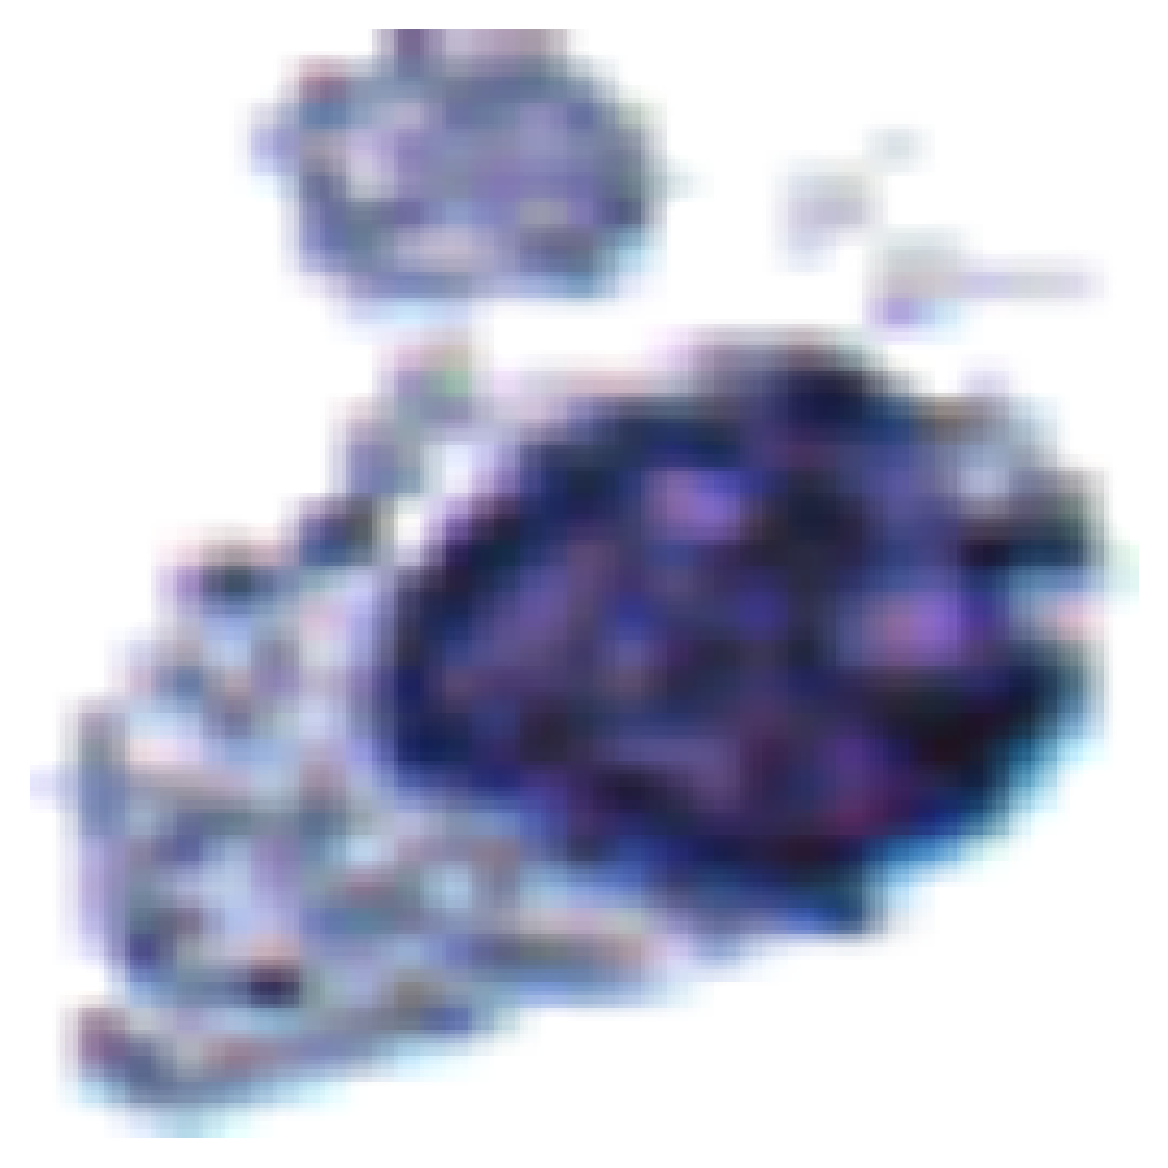

In [13]:
plt.imshow(img)
plt.axis("off")

# Convert to gray & colors, plot

In [14]:
img_gray=rgb2gray(img)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

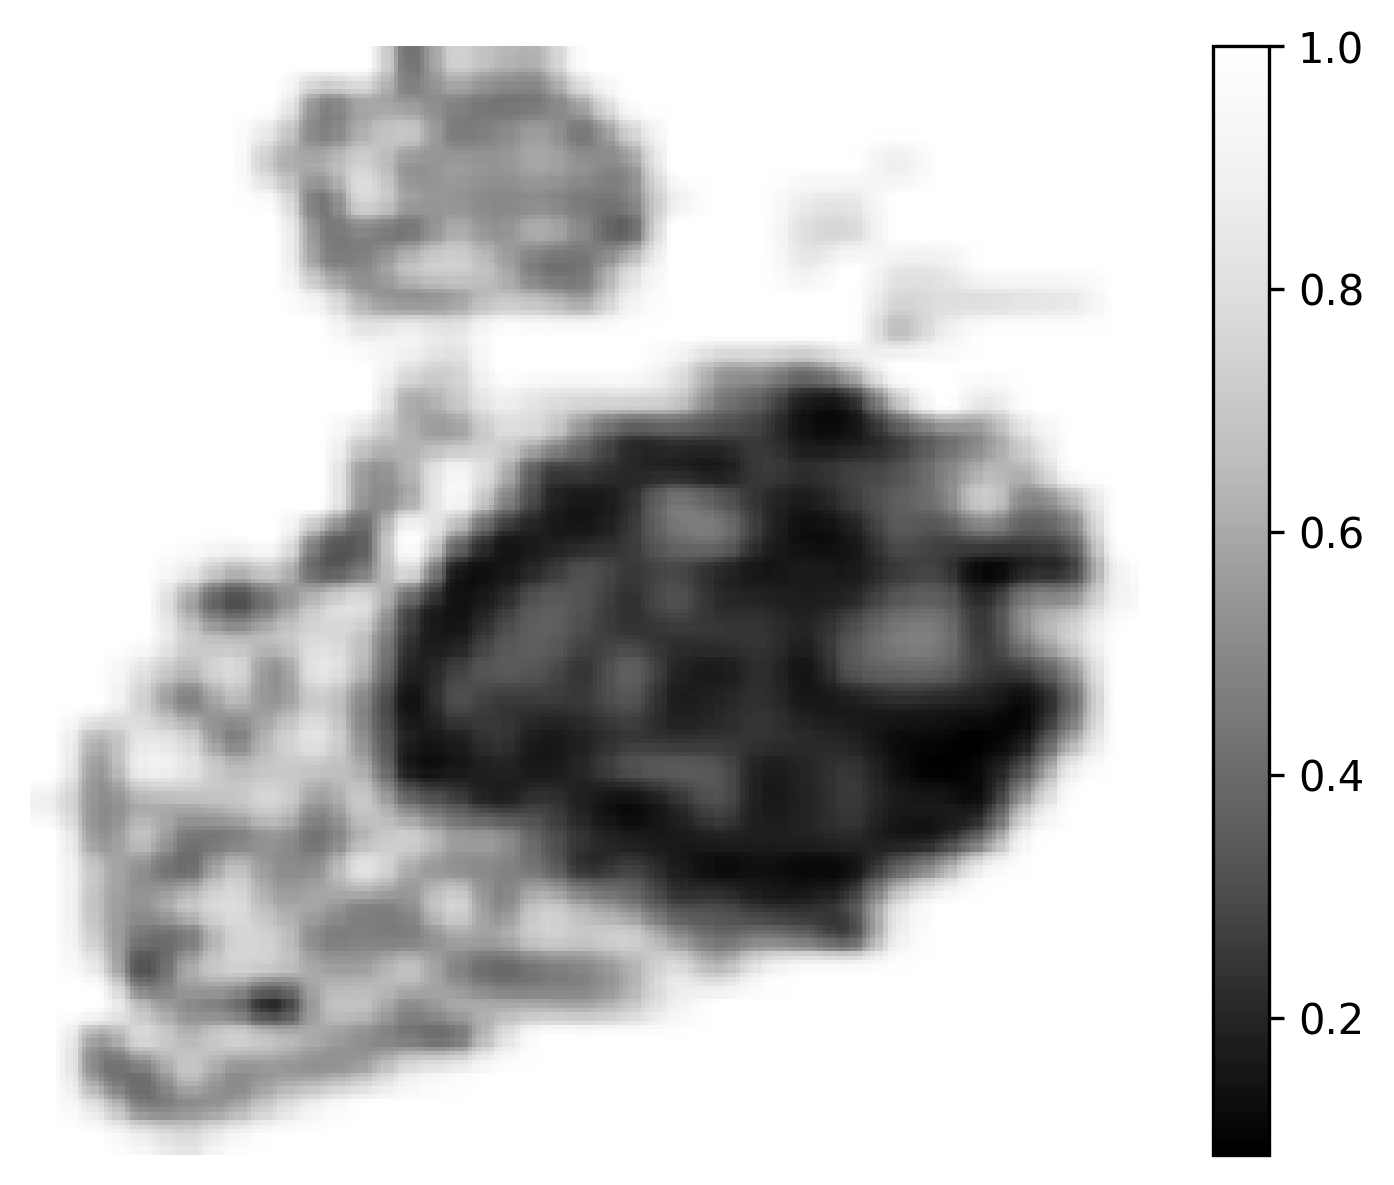

In [15]:
plt.imshow(img_gray,cmap="Greys_r")
plt.colorbar()
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

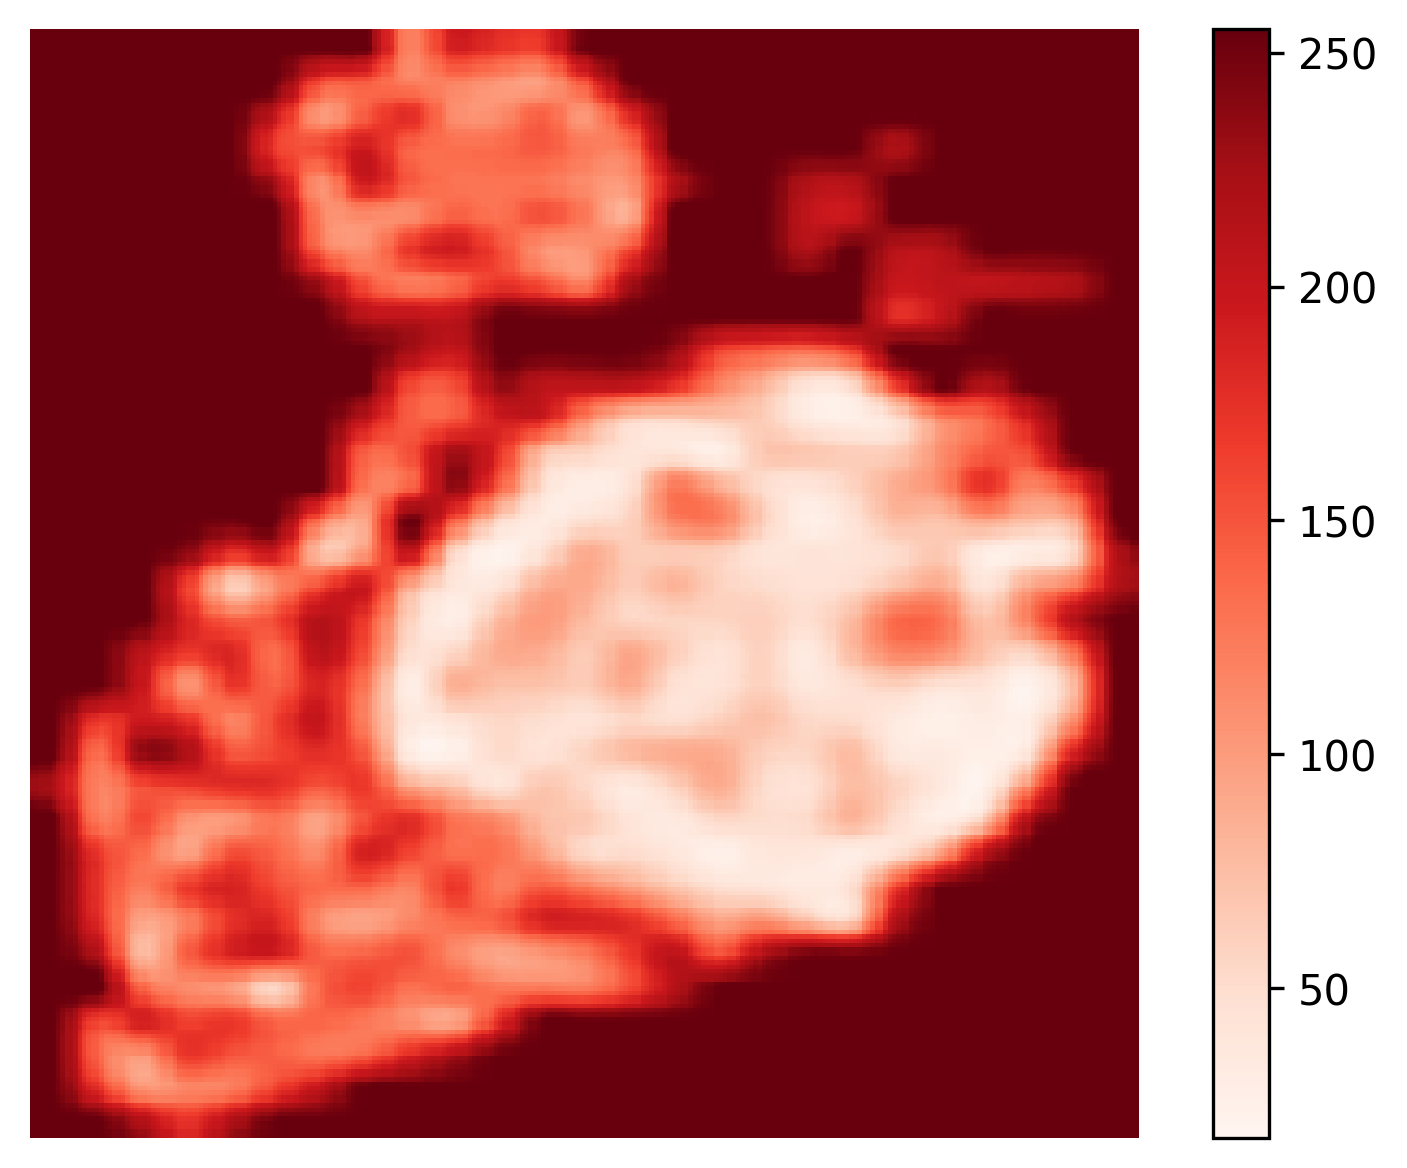

In [16]:
plt.imshow(img[...,0],cmap="Reds")
plt.colorbar()
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

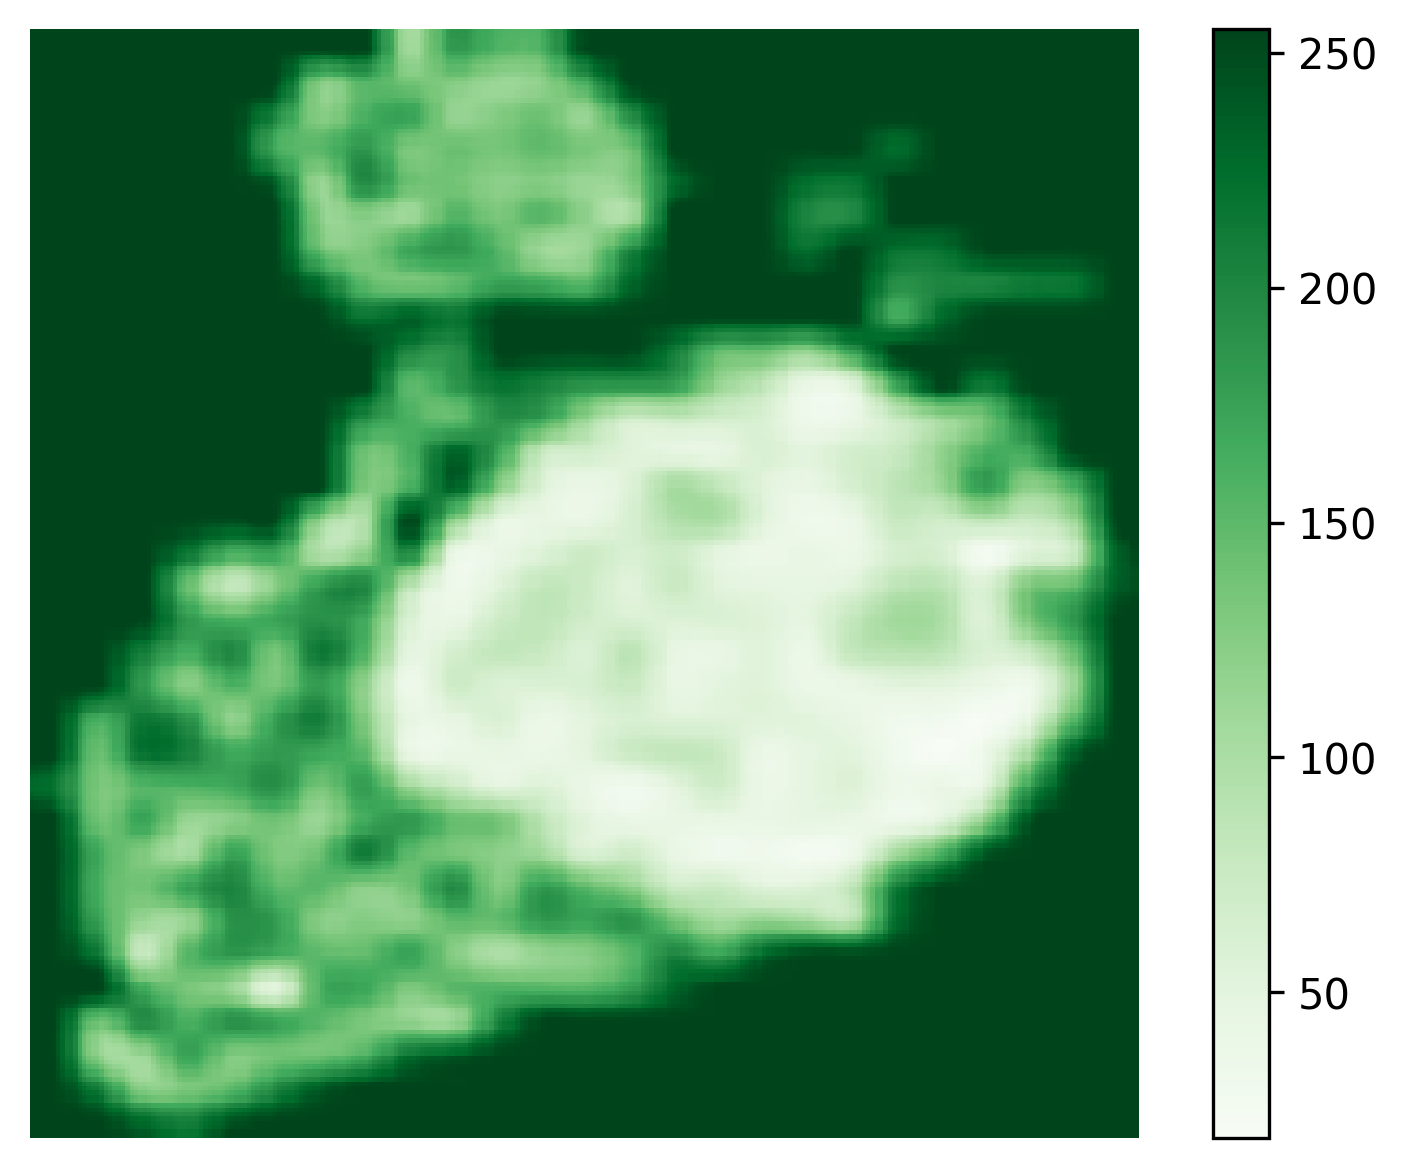

In [17]:
plt.imshow(img[...,1],cmap="Greens")
plt.colorbar()
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

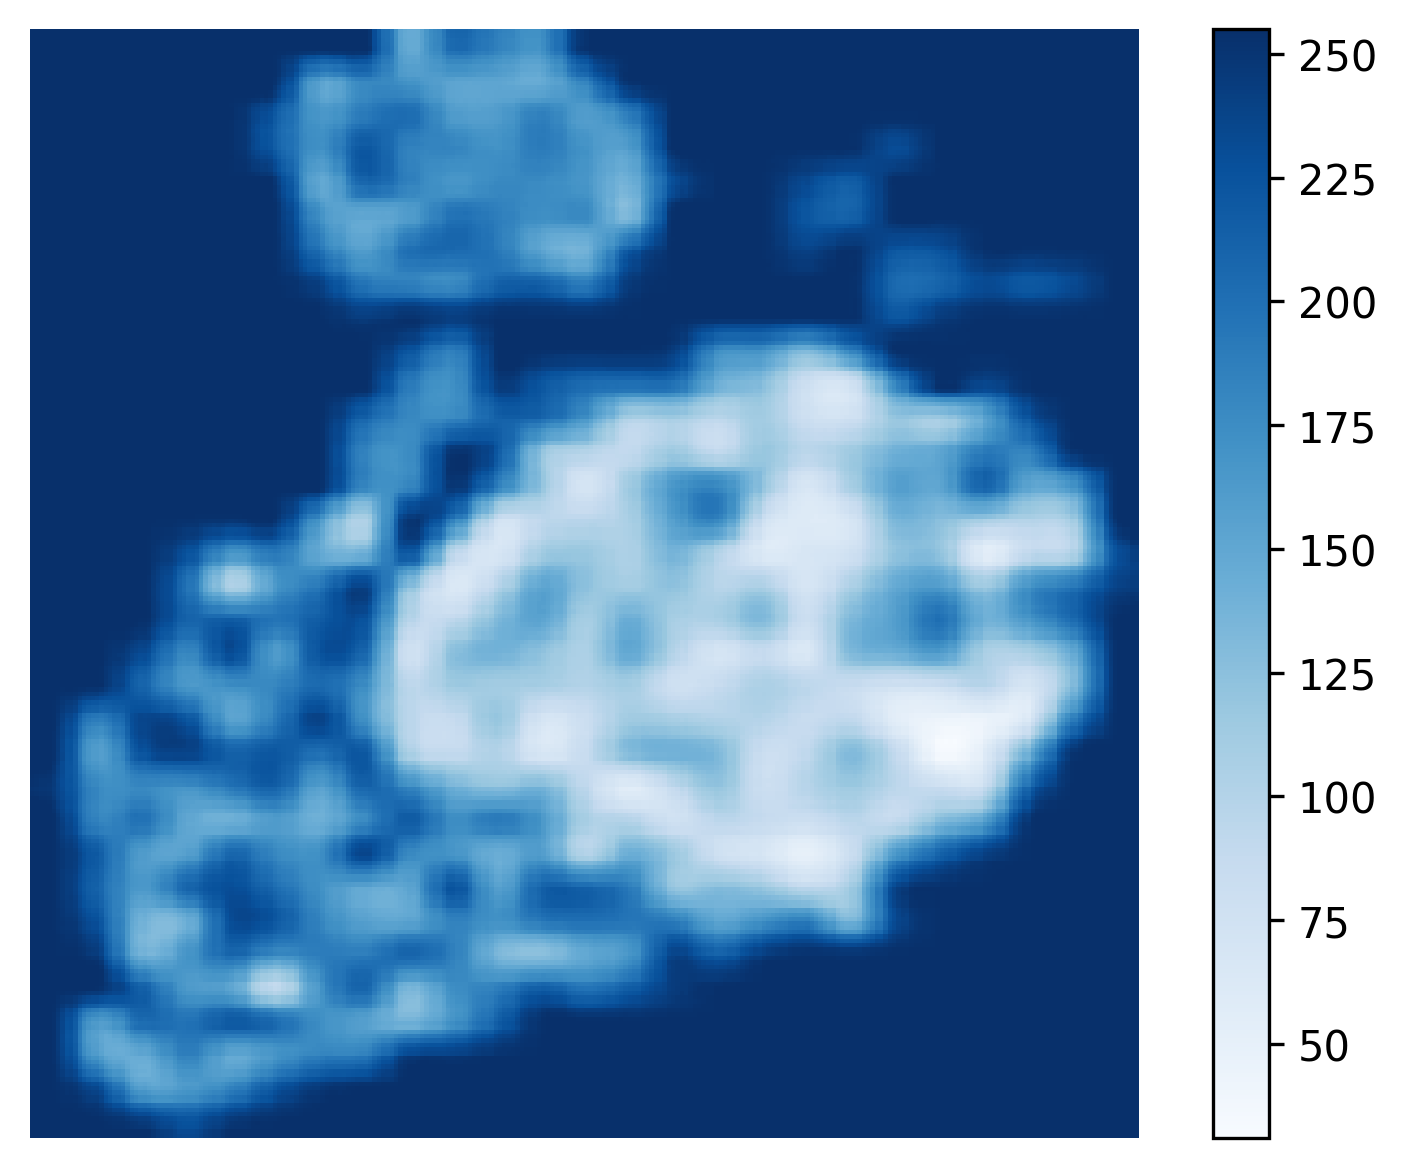

In [18]:
plt.imshow(img[...,2],cmap="Blues")
plt.colorbar()
plt.axis("off")

# Visual display of numerical values in image  (matrix)

In [19]:
img_gray_small=cv2.resize(img_gray,None,fx=1/8,fy=1/8)


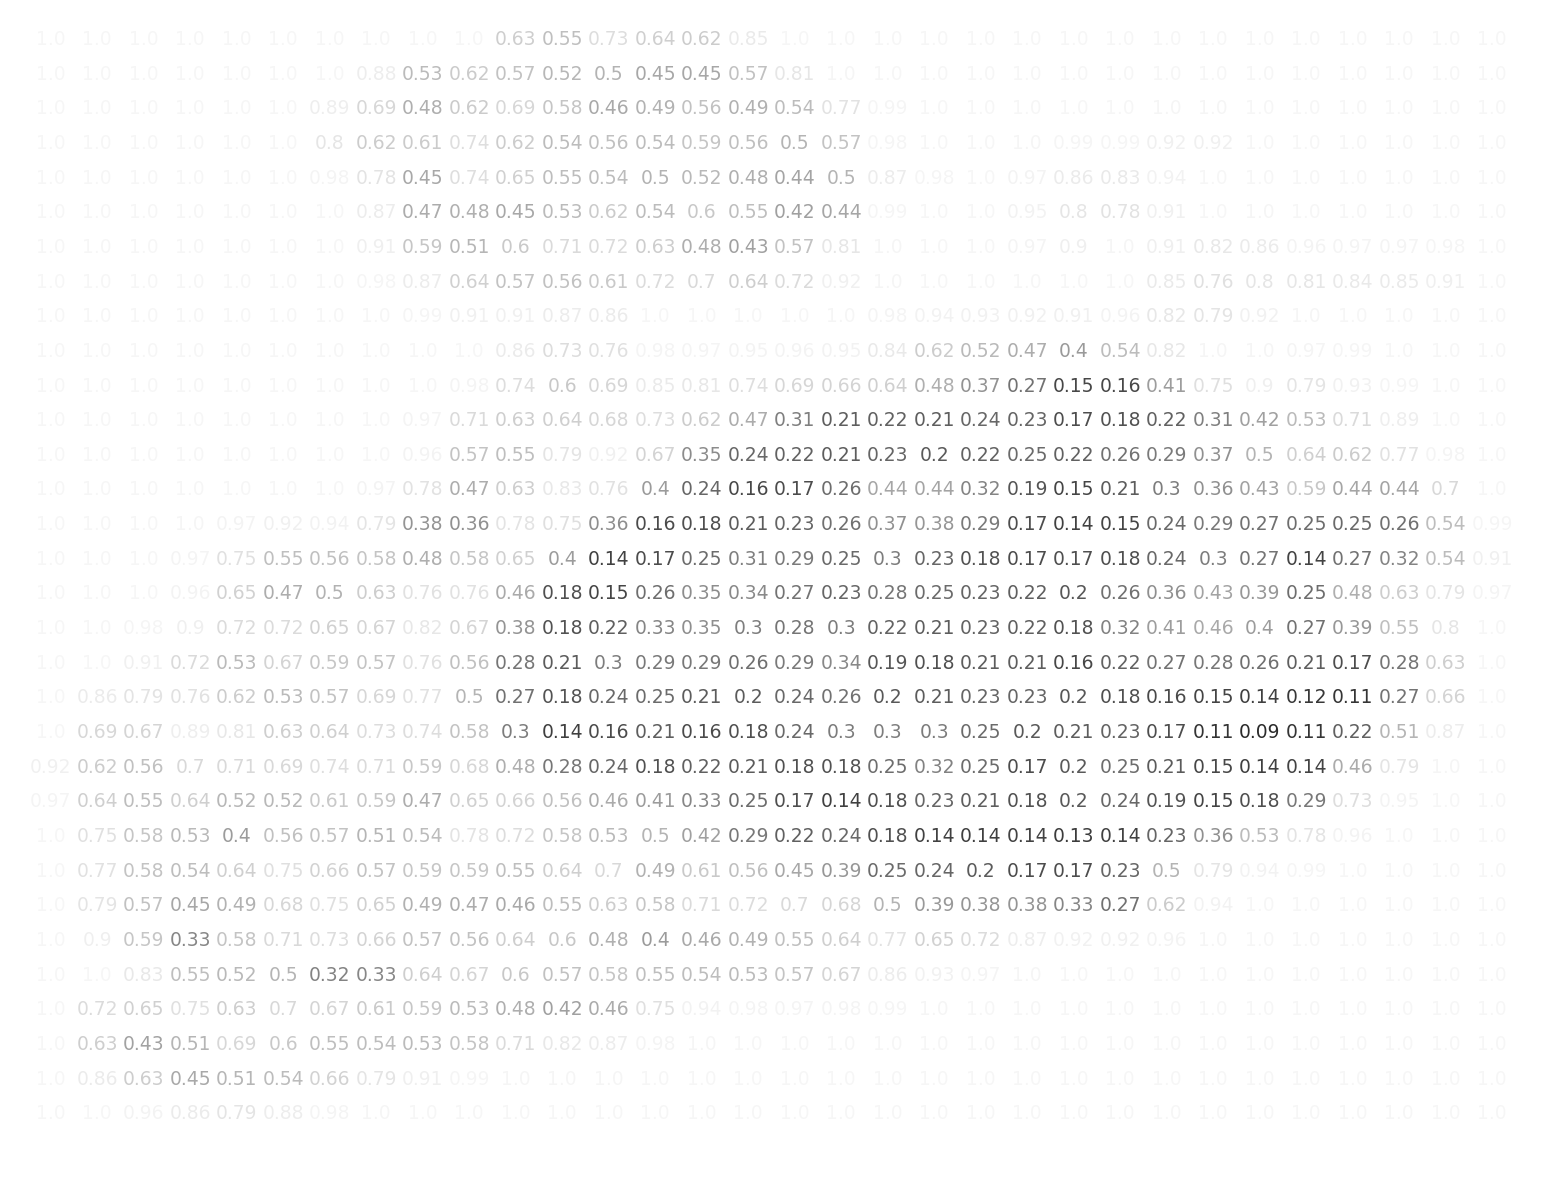

In [20]:
for i in range(img_gray_small.shape[0]):
    for j in range(img_gray_small.shape[0]):
        text = plt.text(j/img_gray_small.shape[0], i/img_gray_small.shape[0], str(round(img_gray_small[i, j],2)),
                       ha="center", va="center", color="k", alpha=(1-img_gray_small[i, j]/1.5)**3, fontsize=4.5)#**2/2
plt.axis("off")
plt.gca().invert_yaxis()

# Thresholding to identify nucleus and cytoplasm

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

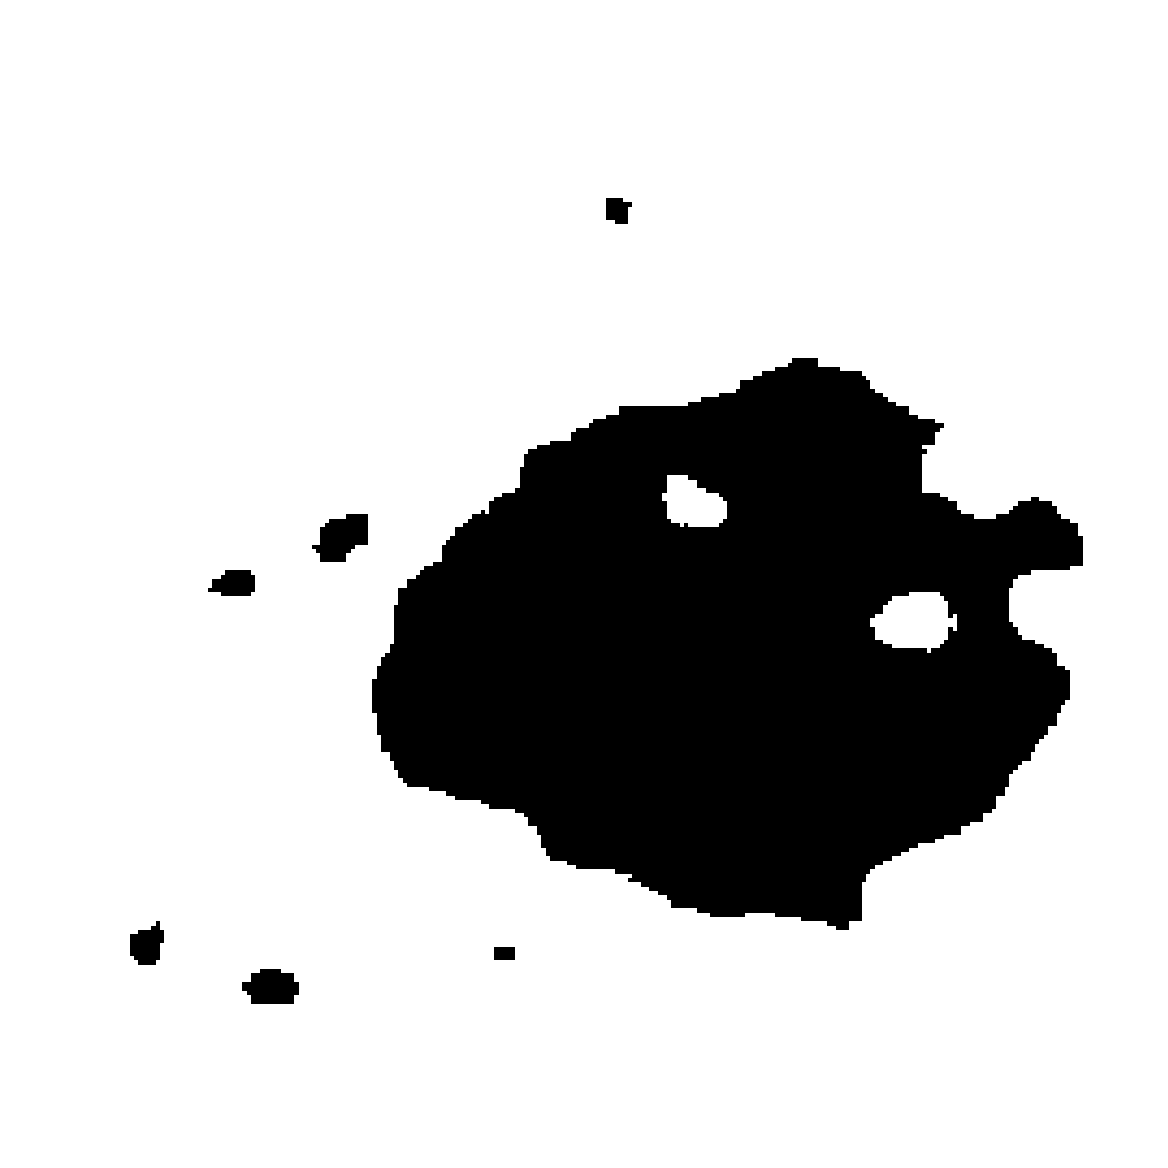

In [21]:
nucleus=img_gray<0.4
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

### Morphological operations to improve nucleus prediction

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

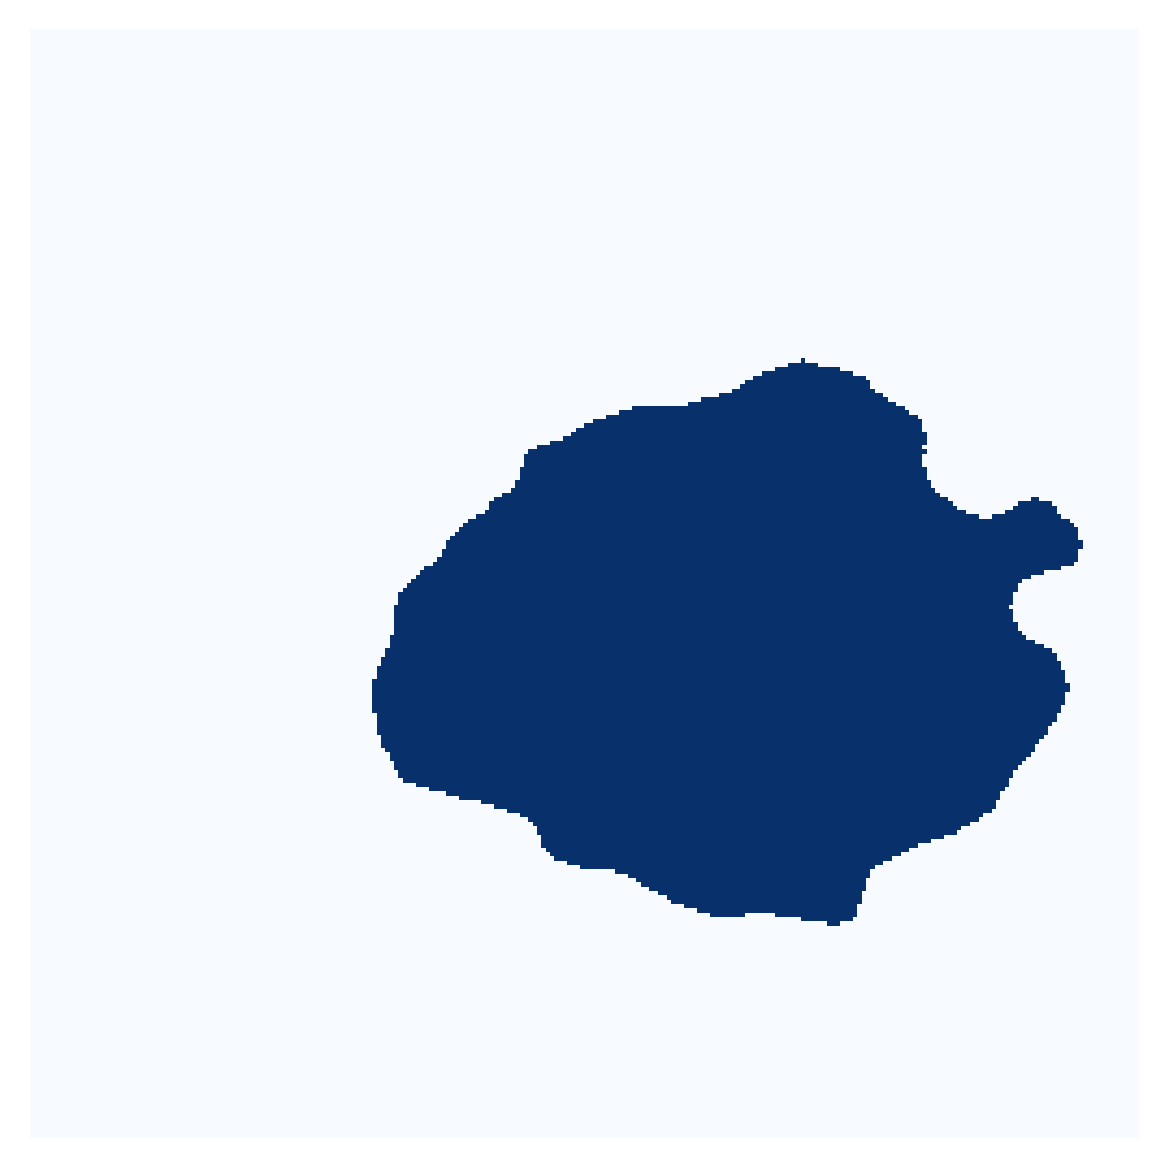

In [38]:
nucleus=img_gray<0.4
nucleus=binary_opening(nucleus,disk(5))
nucleus=binary_closing(nucleus,disk(8))
plt.imshow(nucleus,cmap="Blues")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

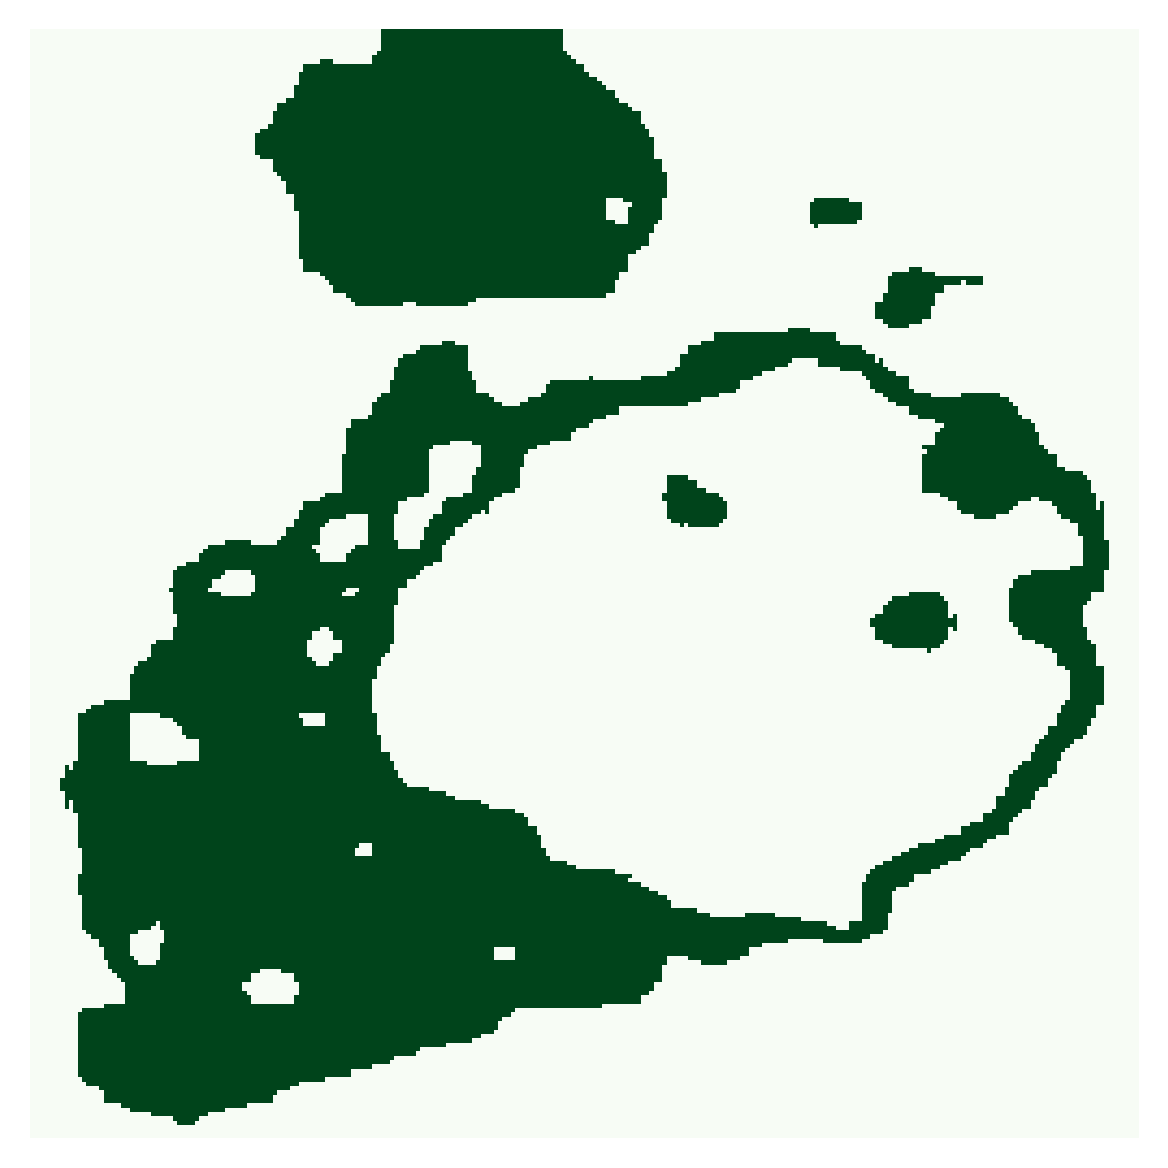

In [39]:
cytoplasm=np.logical_and(img_gray>=0.4,img_gray<=0.8)
plt.imshow(cytoplasm,cmap="Greens")
plt.axis("off")

## Calculate NC ratio

In [40]:
nc_ratio_pred=nucleus.sum()/(nucleus.sum()+cytoplasm.sum())

# Visualize true segmentation mask

In [28]:
lbl=labels[img_idx]

In [29]:
lbl

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(256, 256))

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

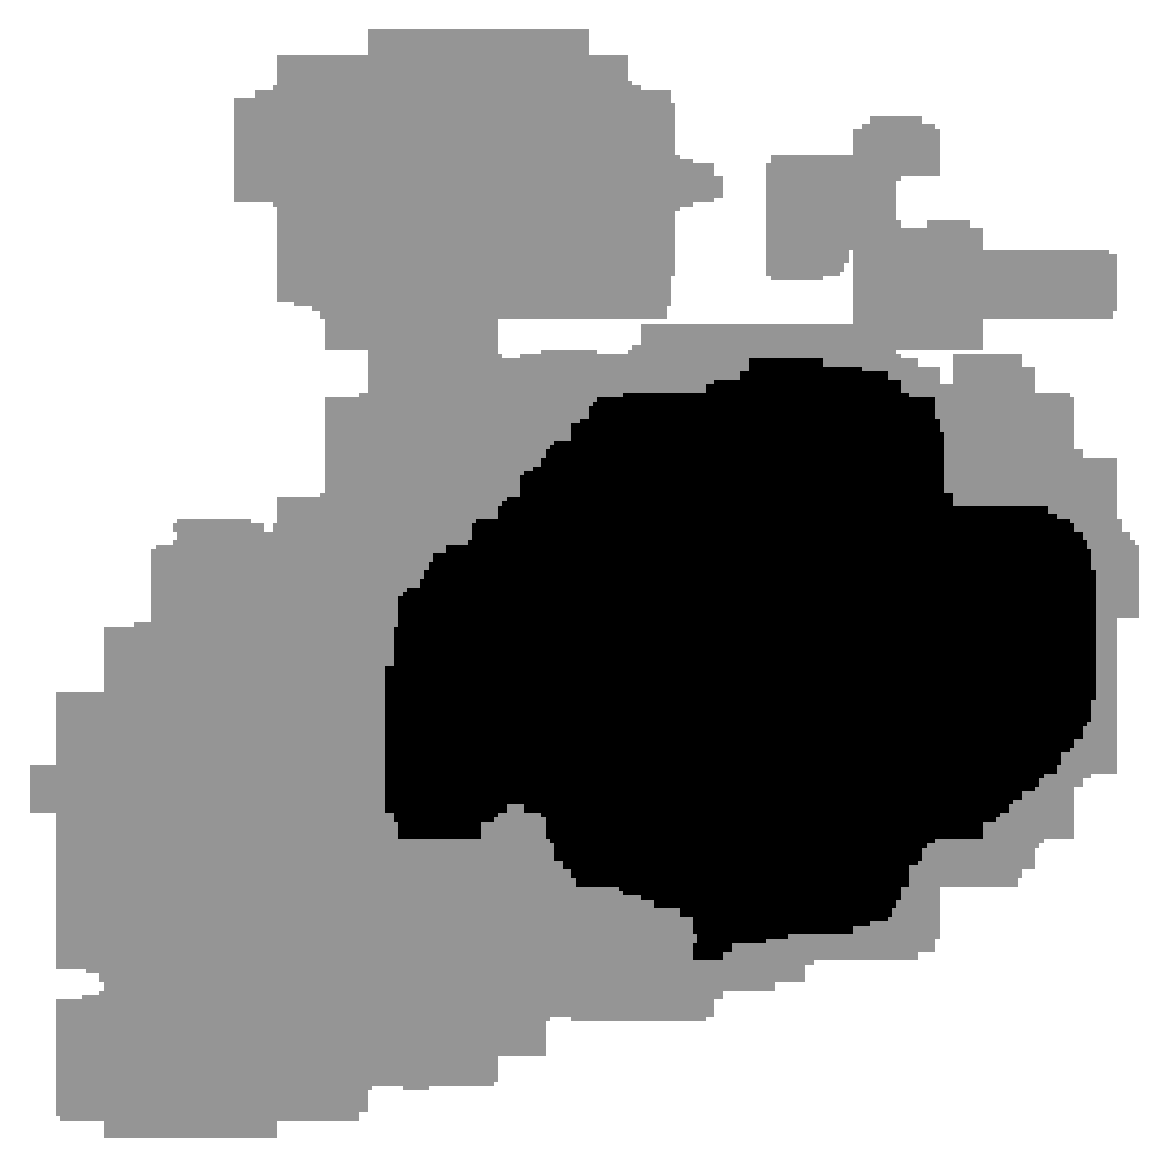

In [30]:
plt.imshow(lbl,cmap="Greys")# plt.imshow((lbl+1)%3,cmap="RdBu")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

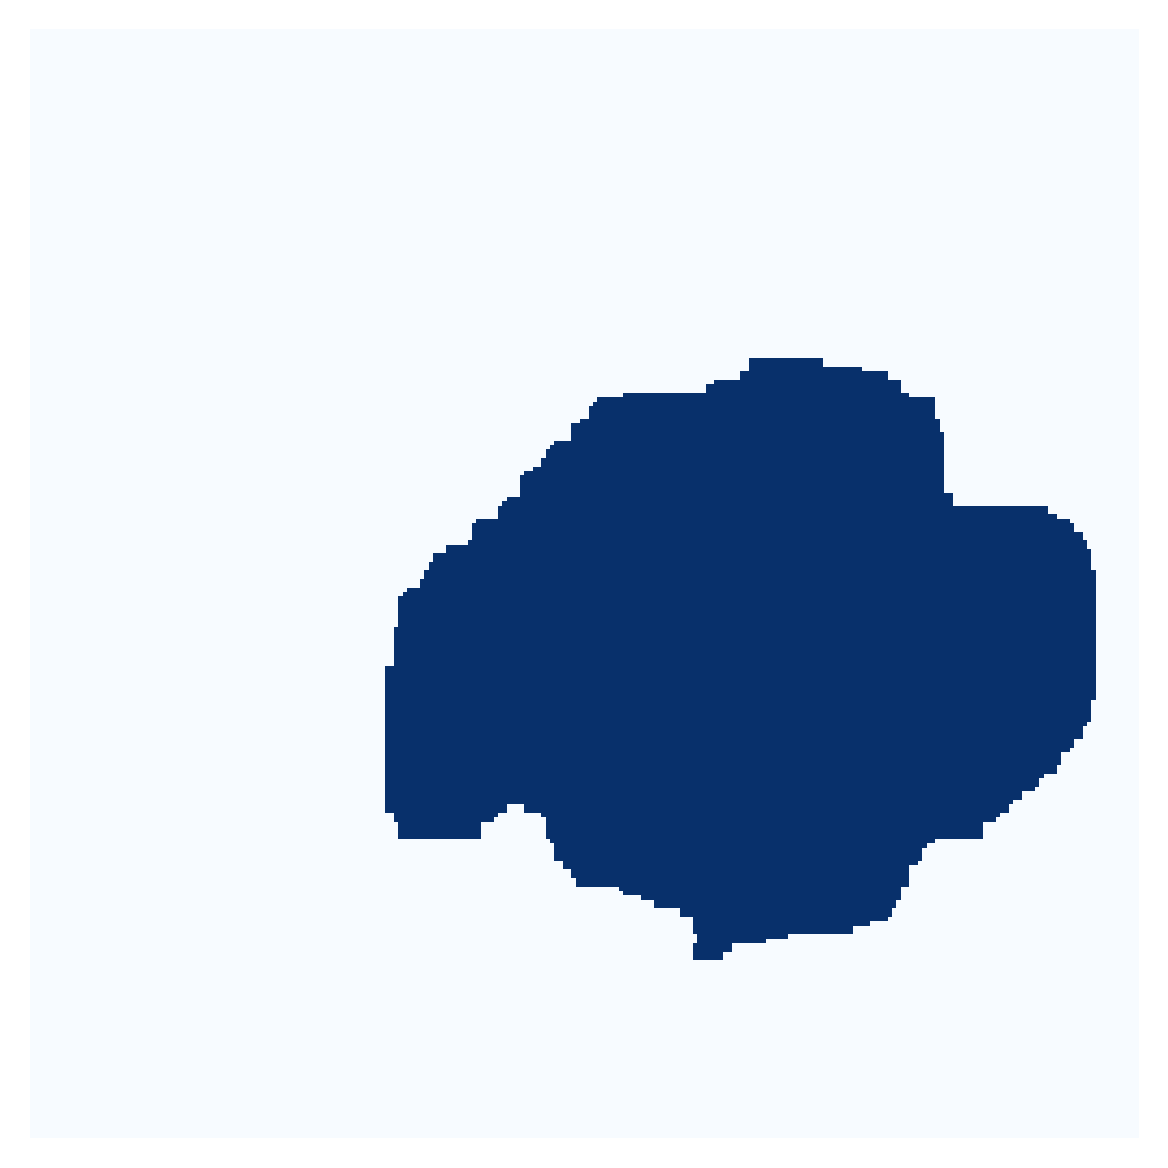

In [34]:
nucleus_true=(lbl==2)
plt.imshow(nucleus_true,cmap="Blues")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

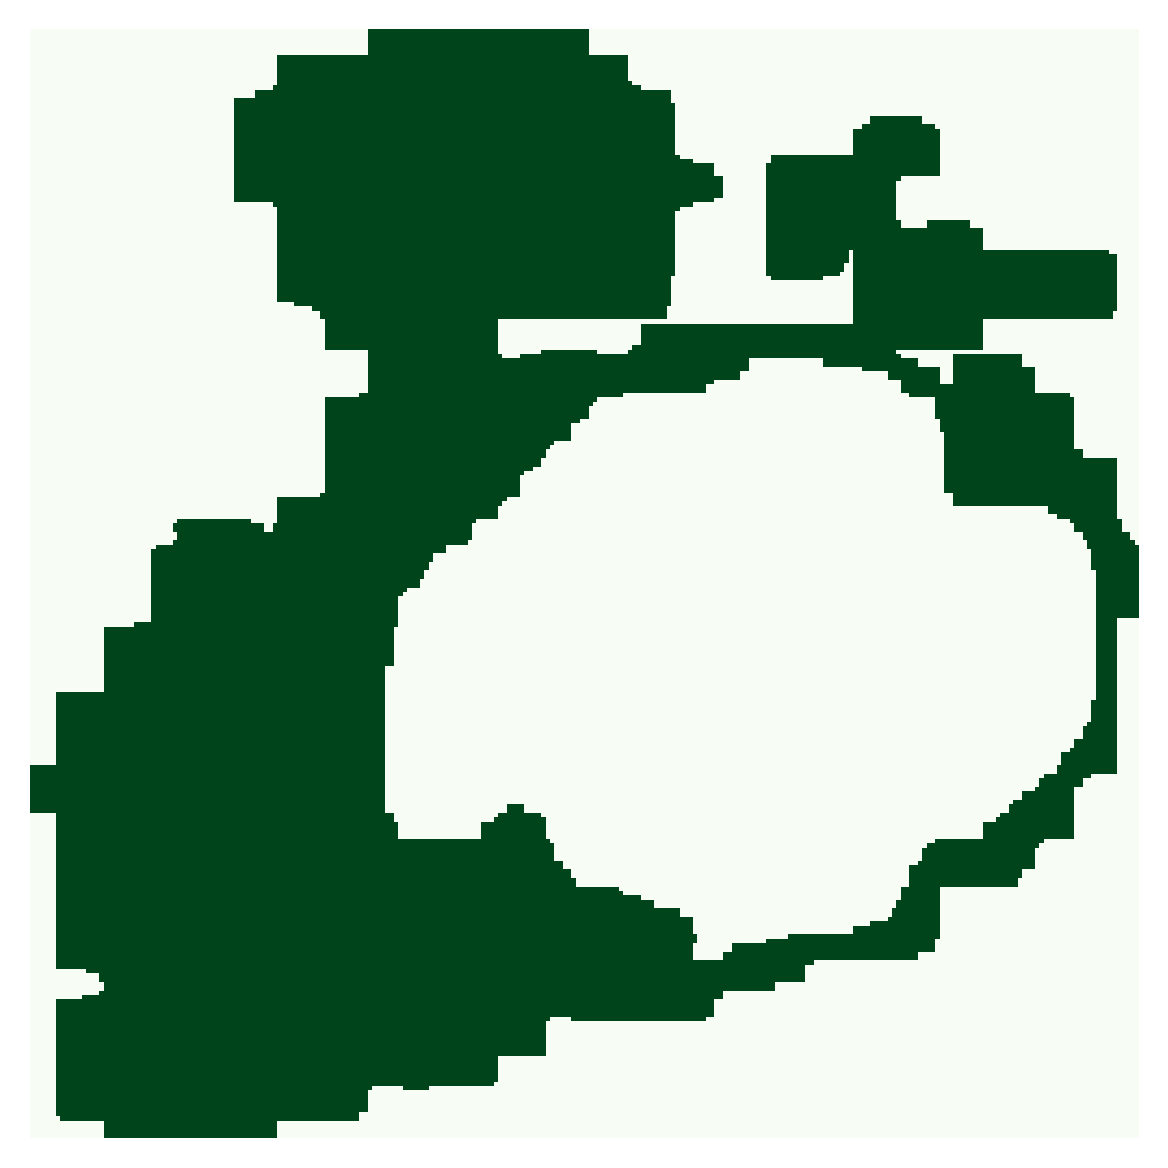

In [35]:
cytoplasm_true=(lbl==1)
plt.imshow(cytoplasm_true,cmap="Greens")
plt.axis("off")

## Calculate true NC ratio and compare

In [41]:
nc_ratio_true=nucleus_true.sum()/(nucleus_true.sum()+cytoplasm_true.sum())

In [42]:
nc_ratio_true,nc_ratio_pred

(np.float64(0.3643818624523361), np.float64(0.41576448792913795))

# Extract bounding box of nucleus

In [43]:
rp=regionprops(nucleus_true.astype(int))
xmin,ymin,xmax,ymax=rp[0].bbox

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

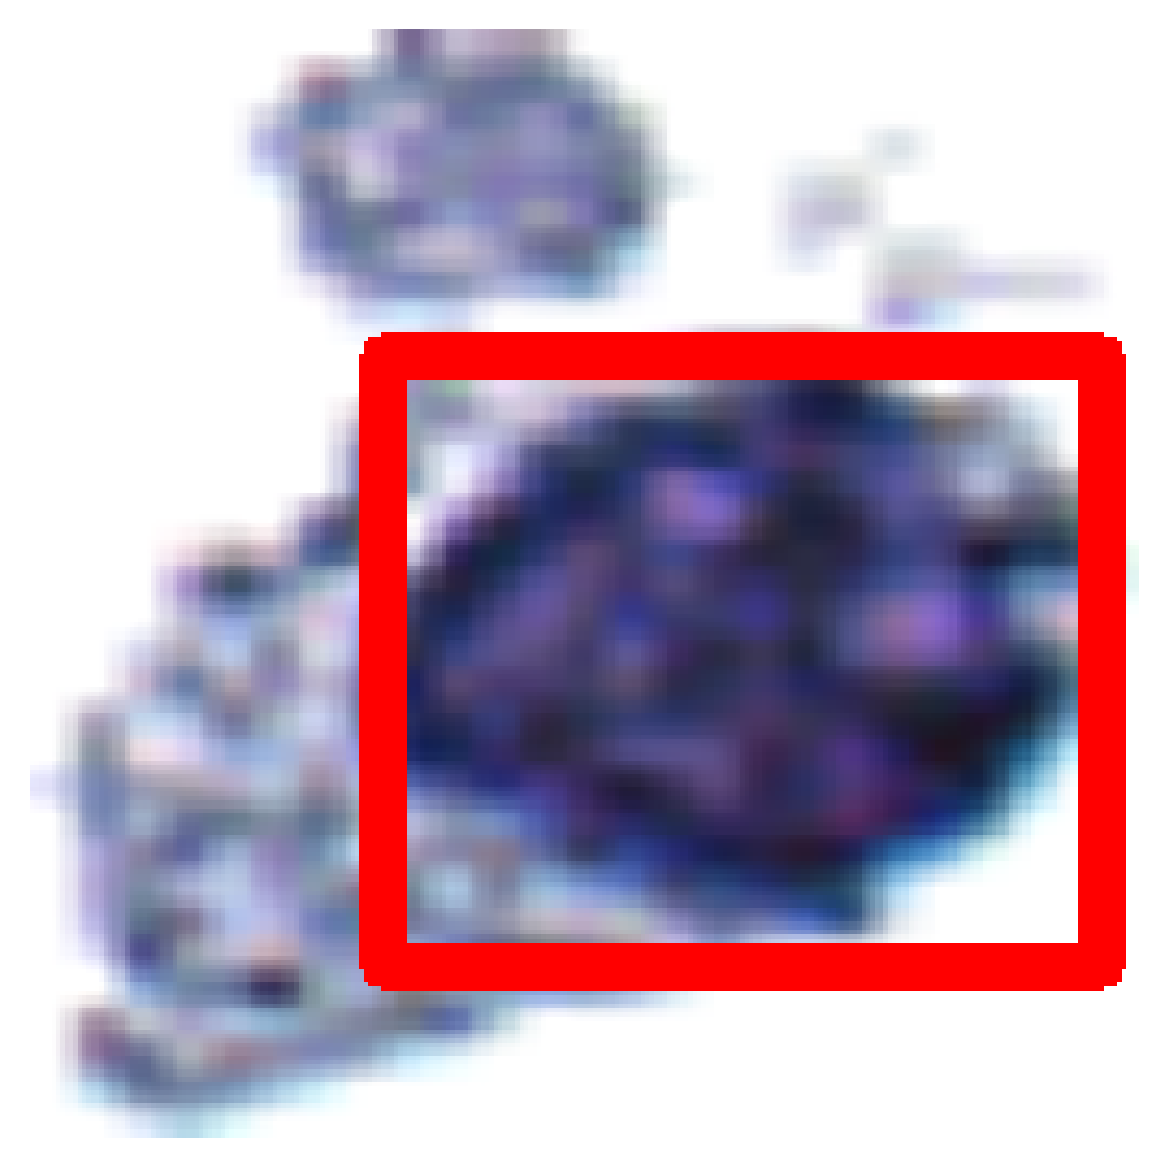

In [44]:
r,c=rectangle_perimeter((xmin,ymin),(xmax,ymax))
rec_lbl=np.zeros(lbl.shape)
rec_lbl[r,c]=1
rec_lbl=binary_dilation(rec_lbl,disk(5))
img_new=img.copy()
img_new[rec_lbl]=[255,0,0]

plt.imshow(img_new)
plt.axis("off")

# Slice image and plot

(np.float64(-0.5), np.float64(163.5), np.float64(138.5), np.float64(-0.5))

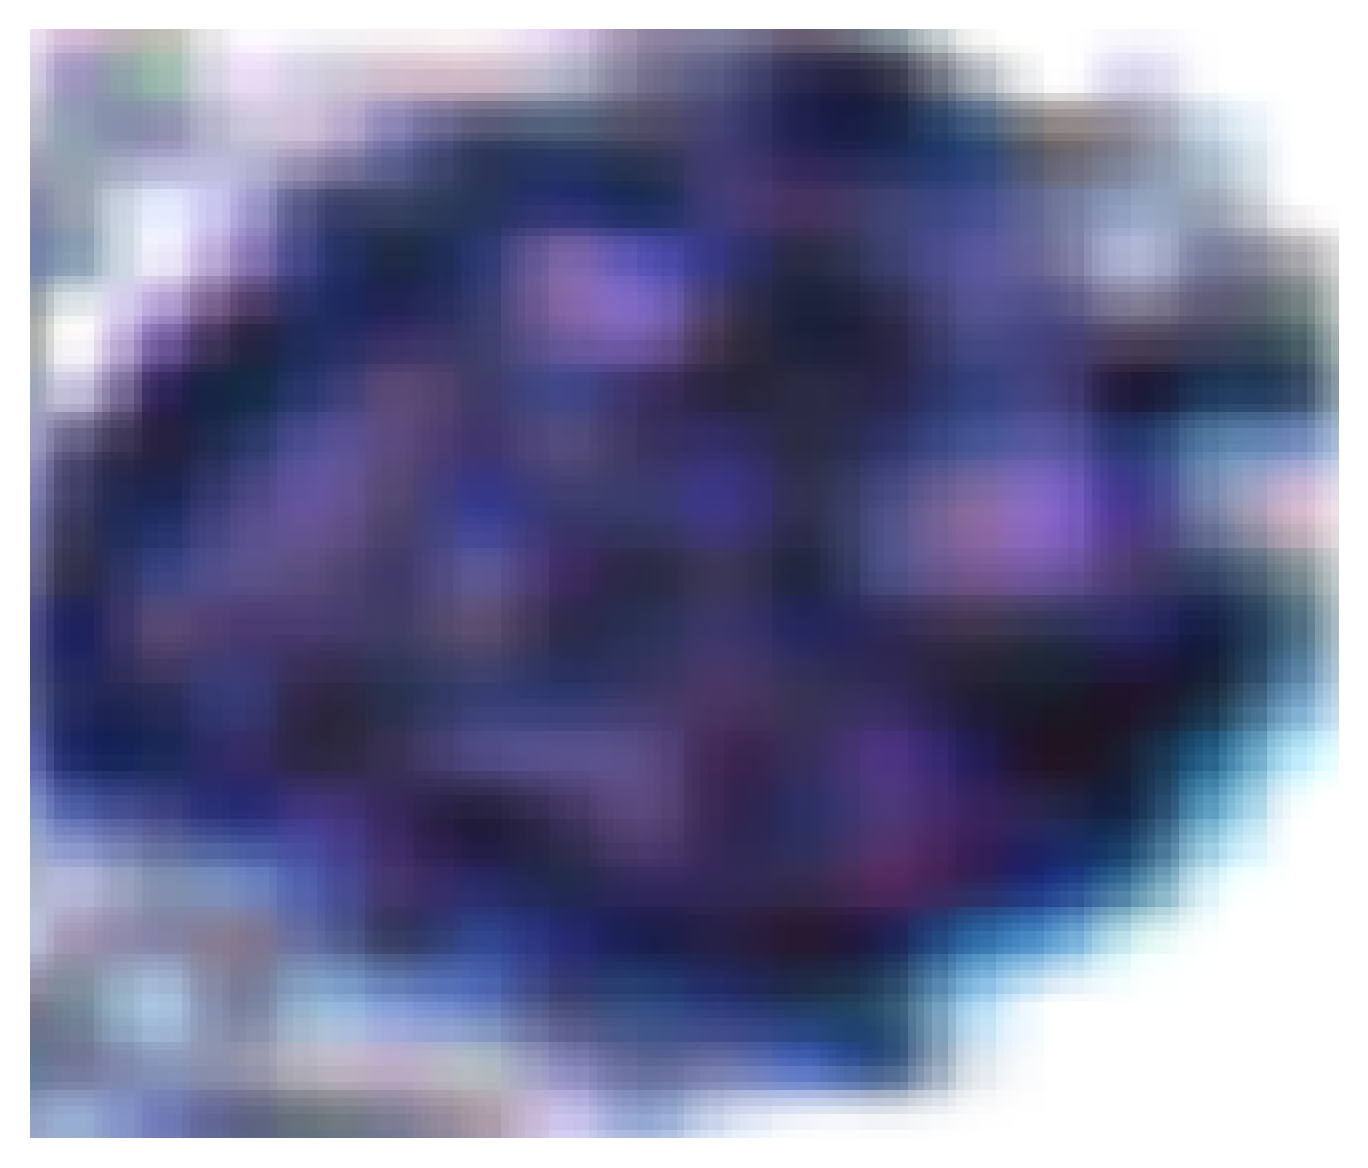

In [45]:
plt.imshow(img[xmin:xmax,ymin:ymax])
plt.axis("off")

# Features & Filters
## Blur image with Gaussian filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08088633875214102..1.0000000000000002].


((np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5)),
 Text(0.5, 1.0, 'Blurred Image'))

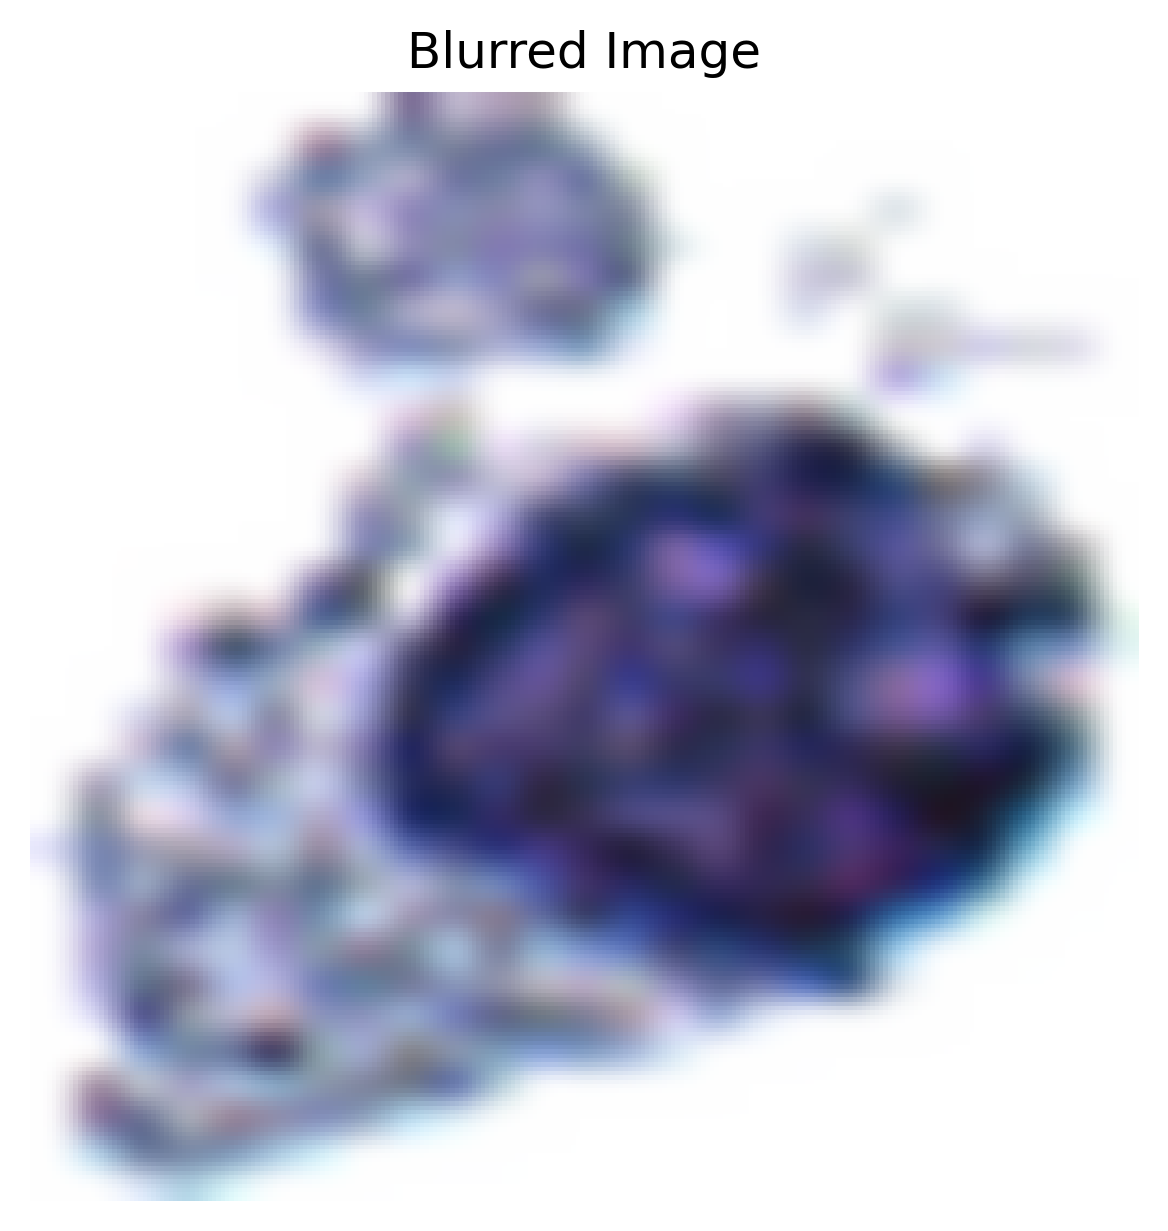

In [ ]:
blurred_image=gaussian(img,sigma=5,channel_axis=2)
plt.imshow(blurred_image)
plt.axis('off'), plt.title('Blurred Image')



## Run sobel filter to detect edges

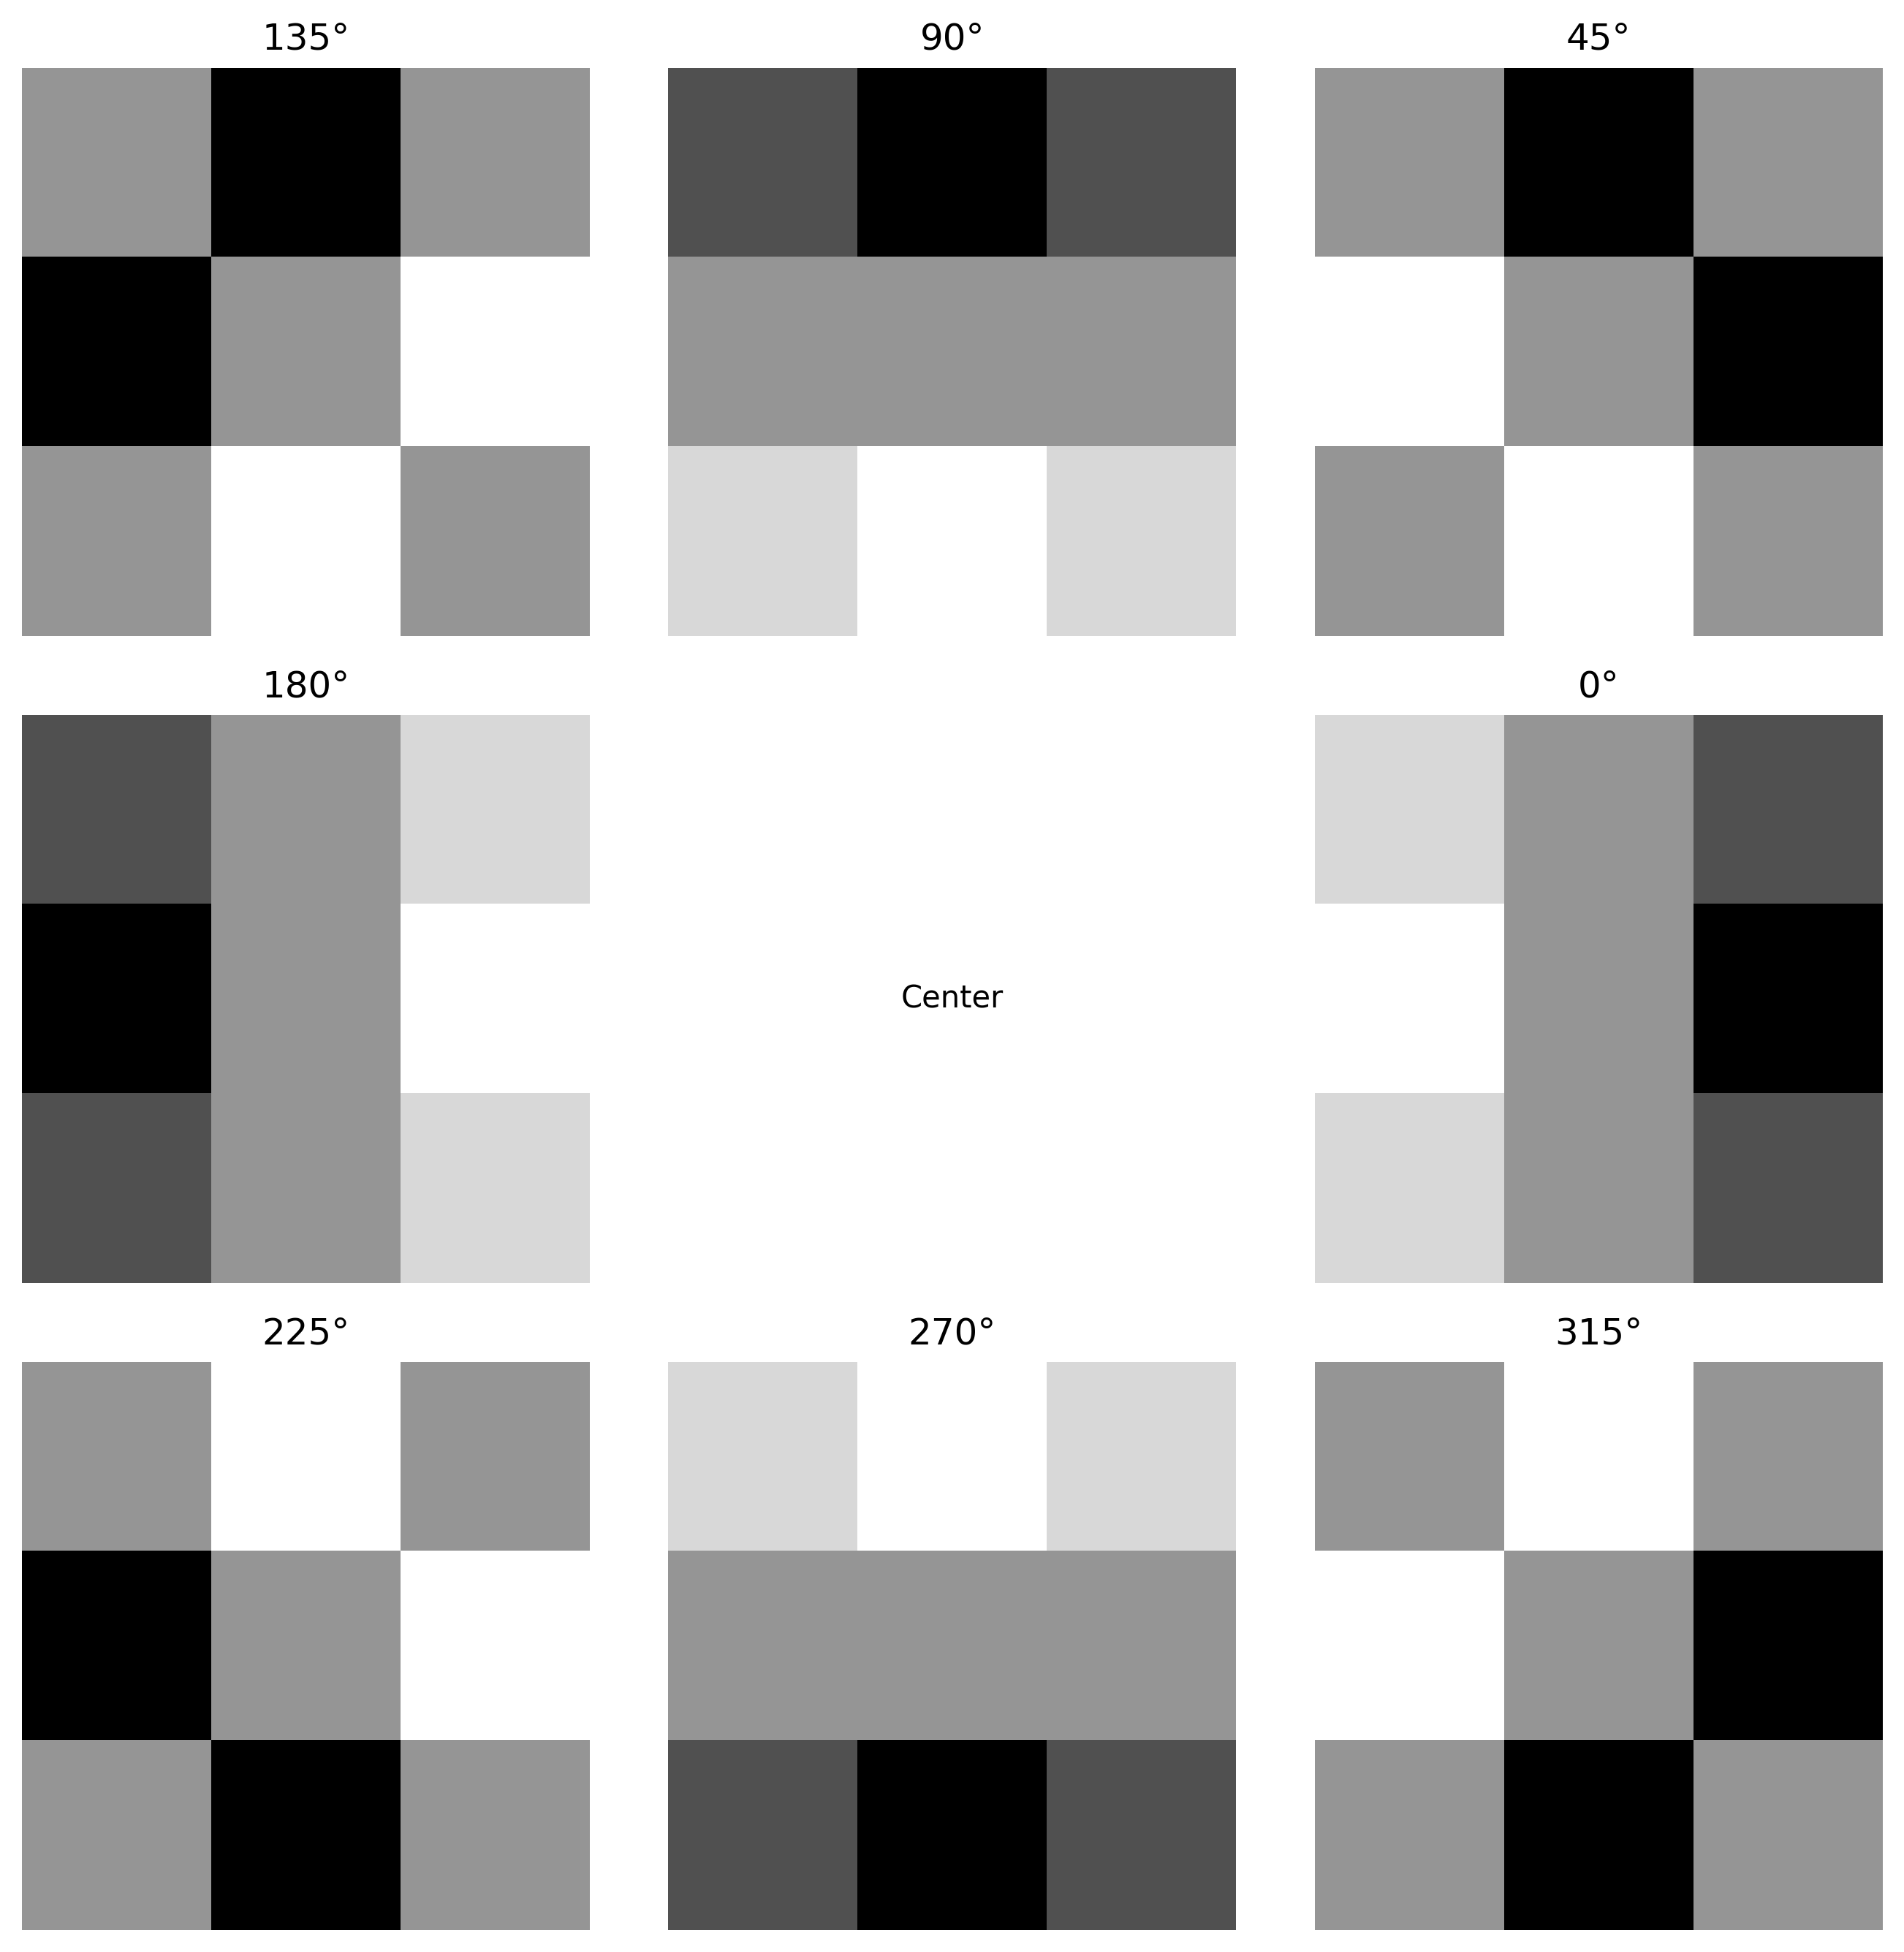

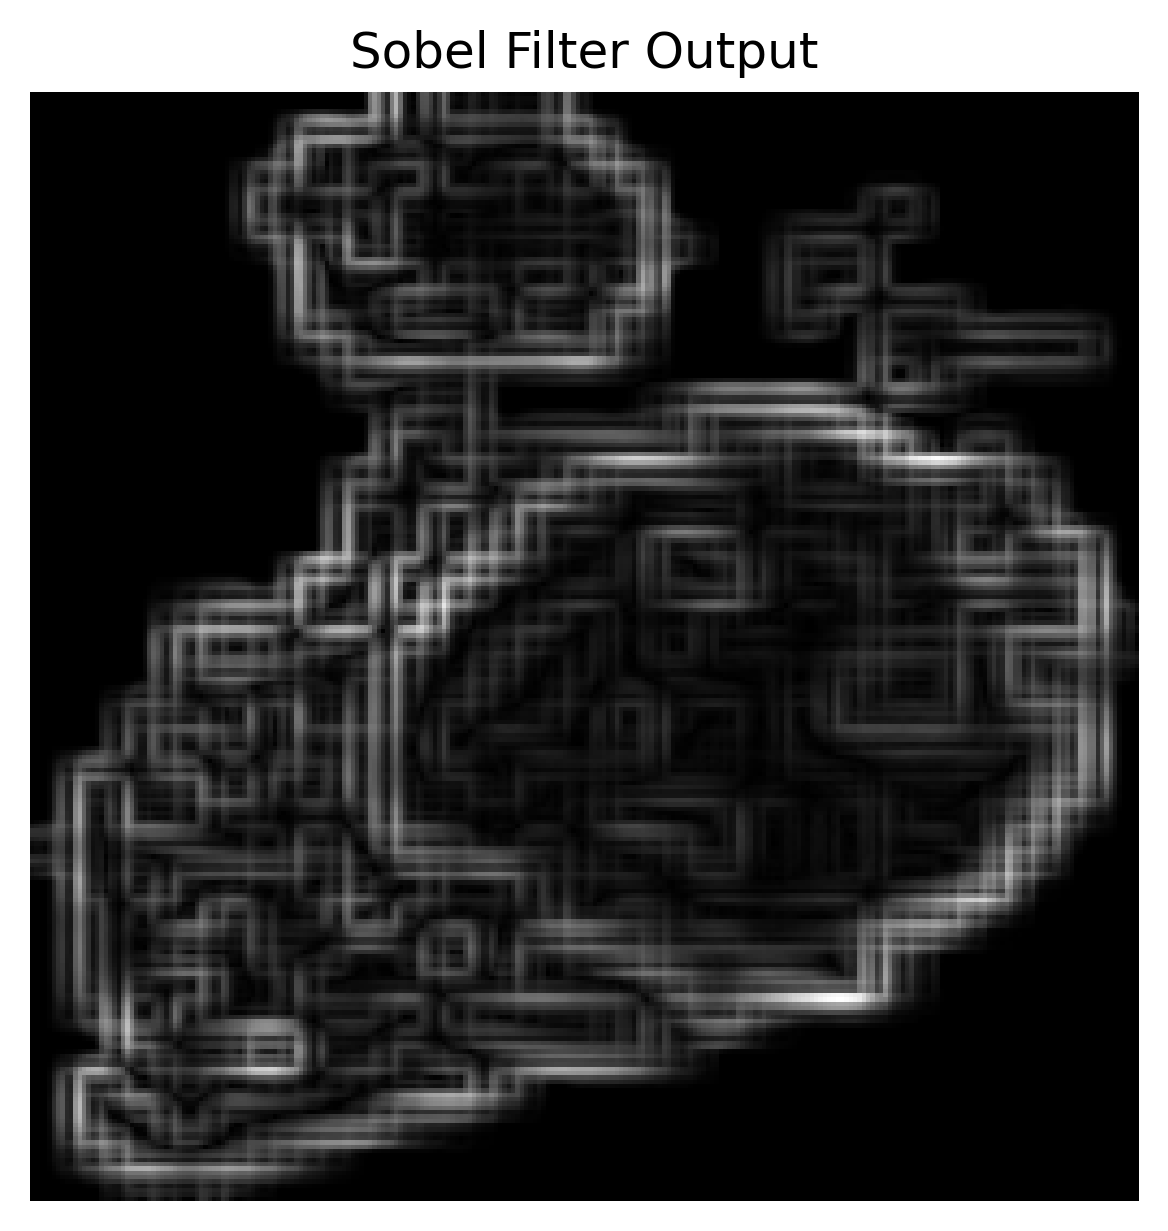

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Base Sobel X filter & rotated versions
base = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
angles = [135, 90, 45, 180, 0, 225, 270, 315]
filters_rot = [rotate(base, a, reshape=False) for a in angles]

# Plot filters in 3x3 grid
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
ax = ax.ravel()
for i, (a, f) in enumerate(zip(angles, filters_rot)):
    idx = i if i < 4 else i + 1
    ax[idx].imshow(f, cmap='Greys'), ax[idx].set_title(f'{a}°'), ax[idx].axis('off')
ax[4].axis('off')
ax[4].text(0.5, 0.5, 'Center', ha='center', va='center')
plt.tight_layout(), plt.show()

# Show default sobel magnitude
plt.imshow(sobel(img_gray), cmap='gray')
plt.axis('off'), plt.title('Sobel Filter Output')
plt.show()

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

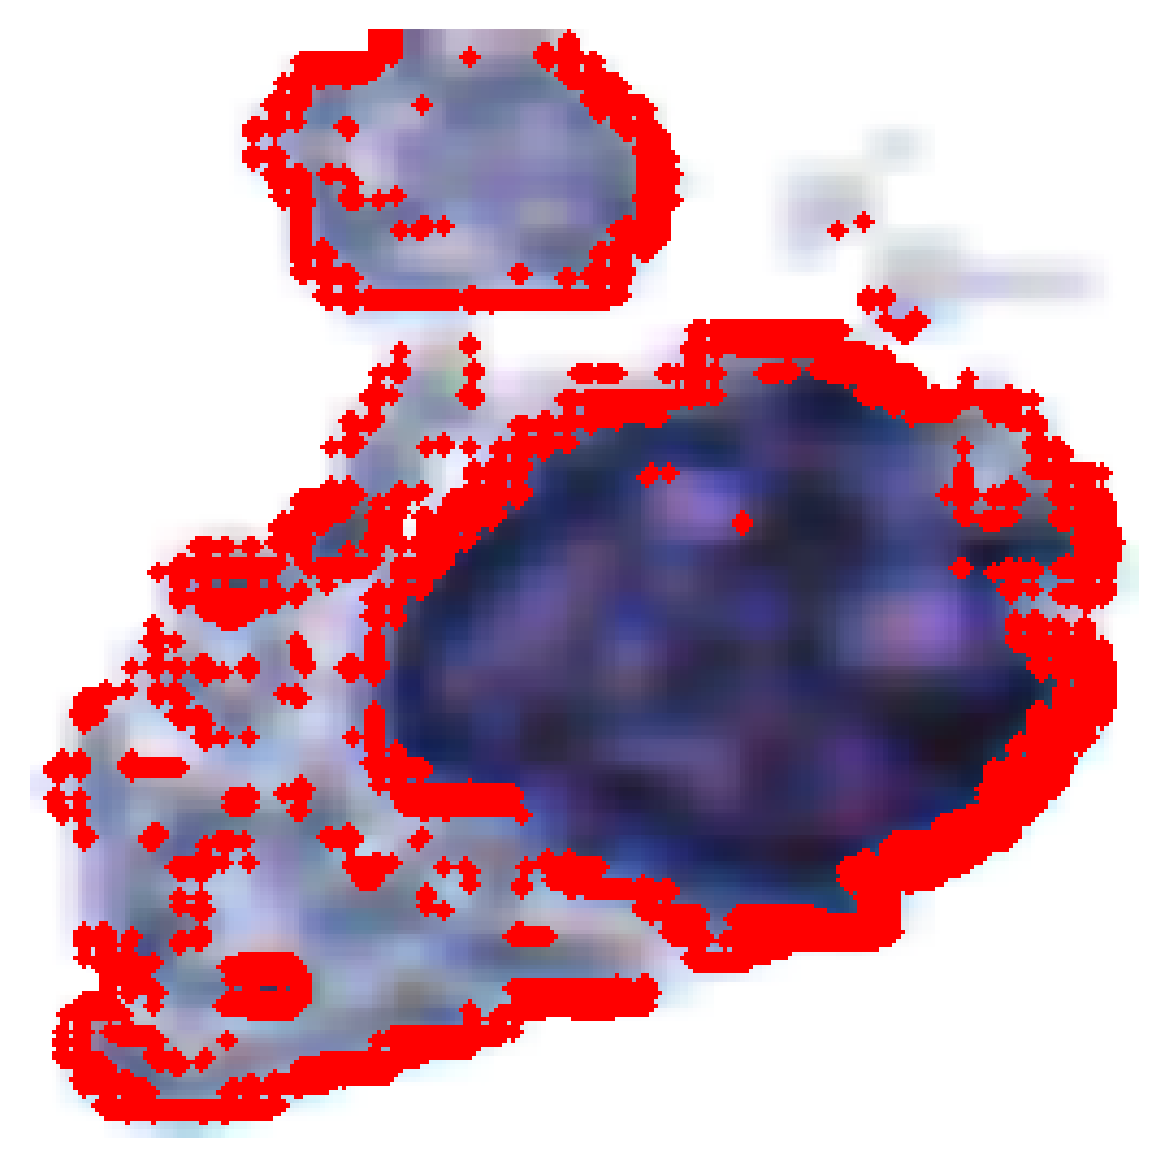

In [51]:
edges=binary_opening(sobel(img_gray)>0.03,disk(2))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")

## Smooth sobel filter with additional morphological operations to improve edge detection

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

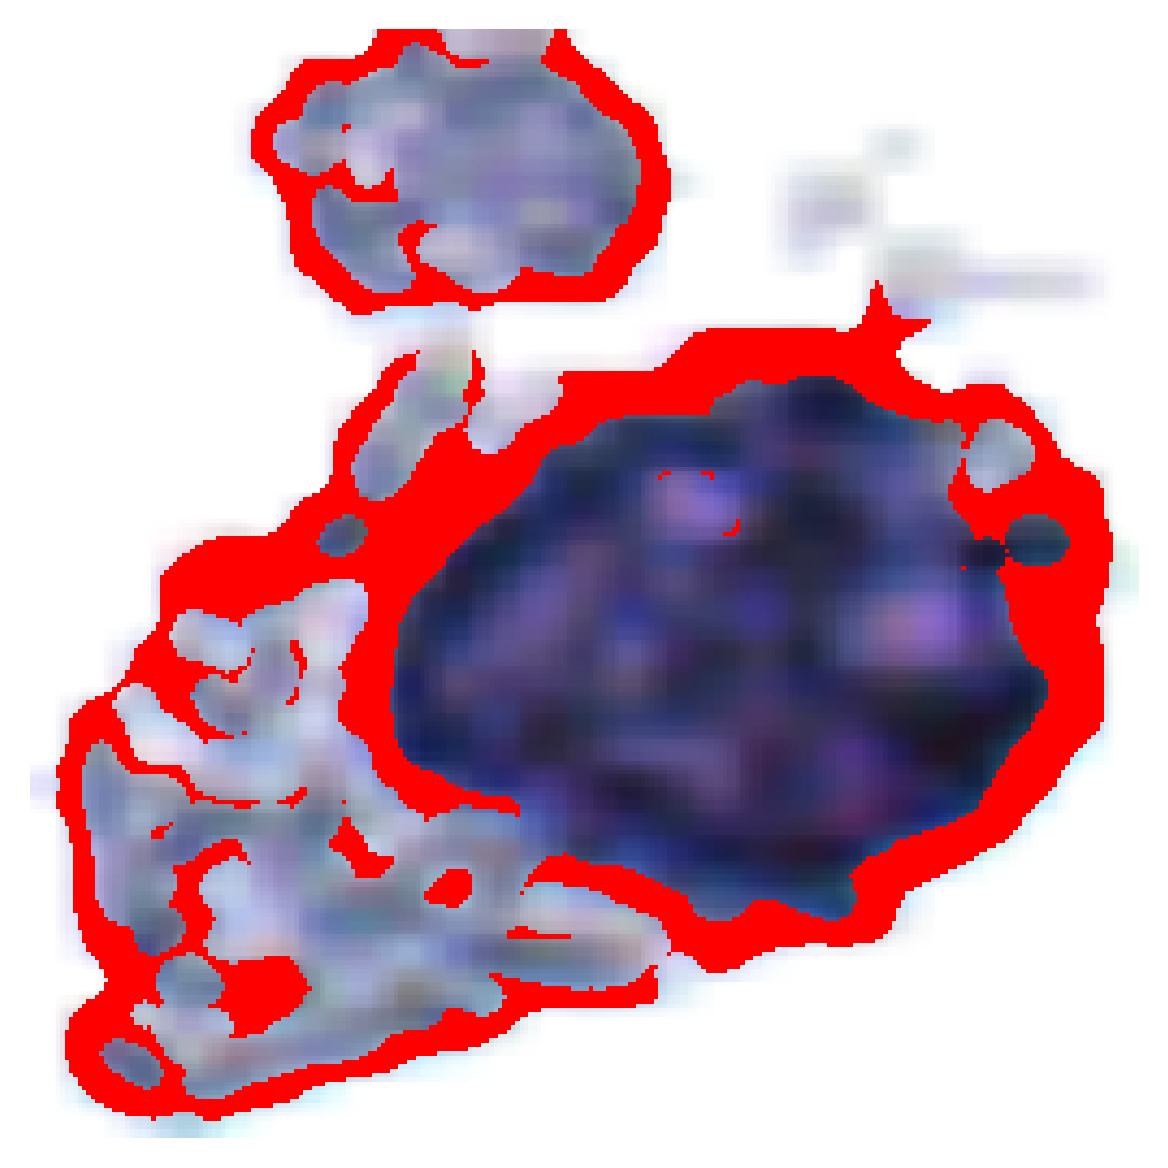

In [52]:
edges=gaussian(sobel(img_gray),sigma=2)>0.03
edges=binary_erosion(binary_opening(edges,disk(2)),disk(3))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")

## Canny edge detection

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

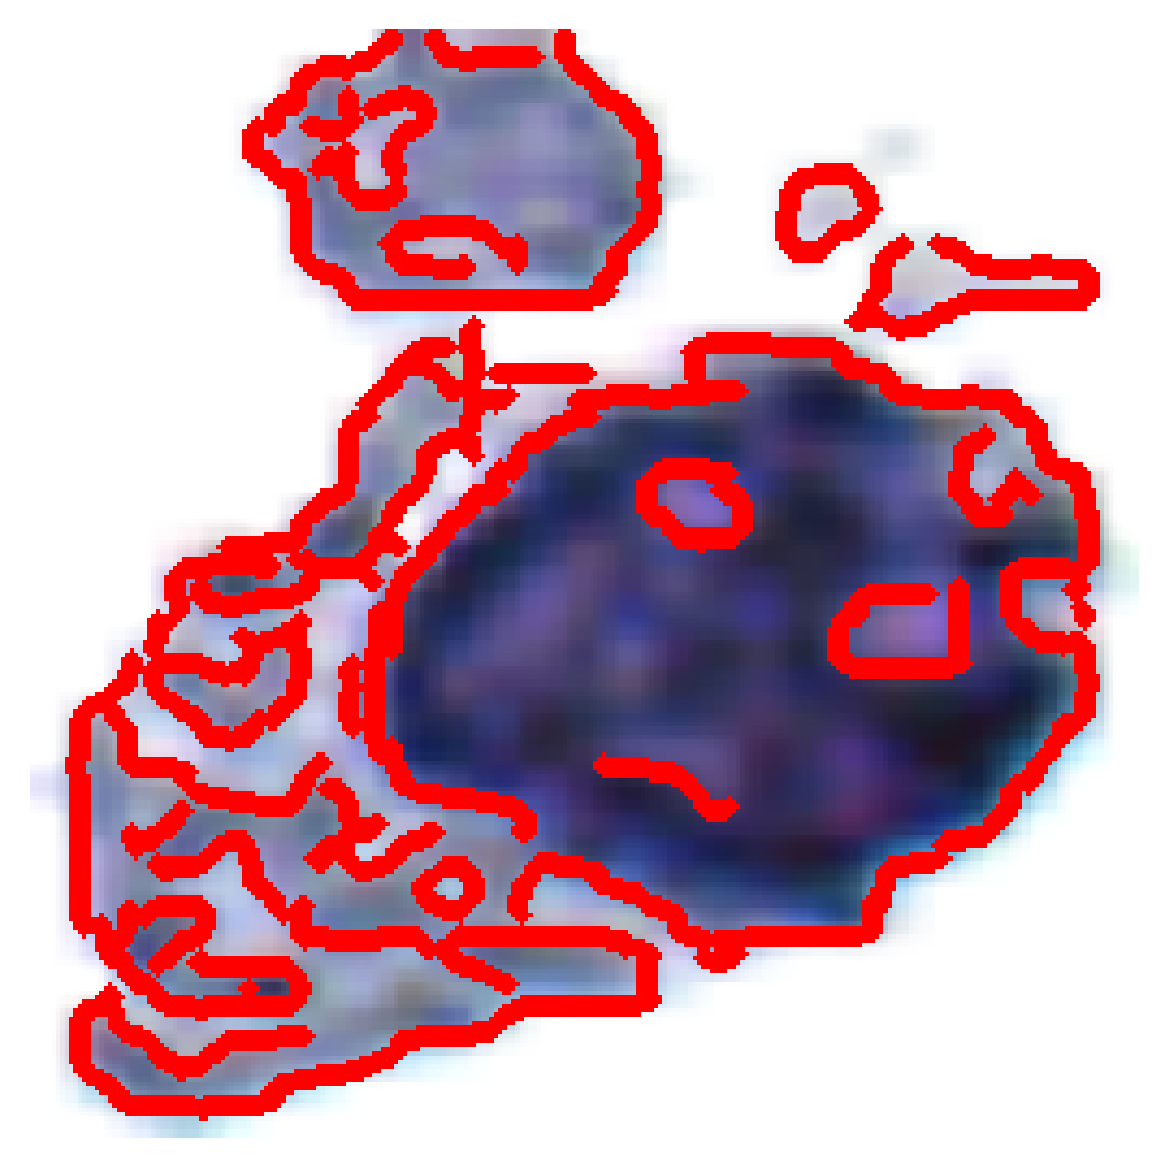

In [53]:
edges=binary_dilation(canny(img_gray, sigma=2.),disk(2))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")


# Connected component analysis
### Identify cell

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

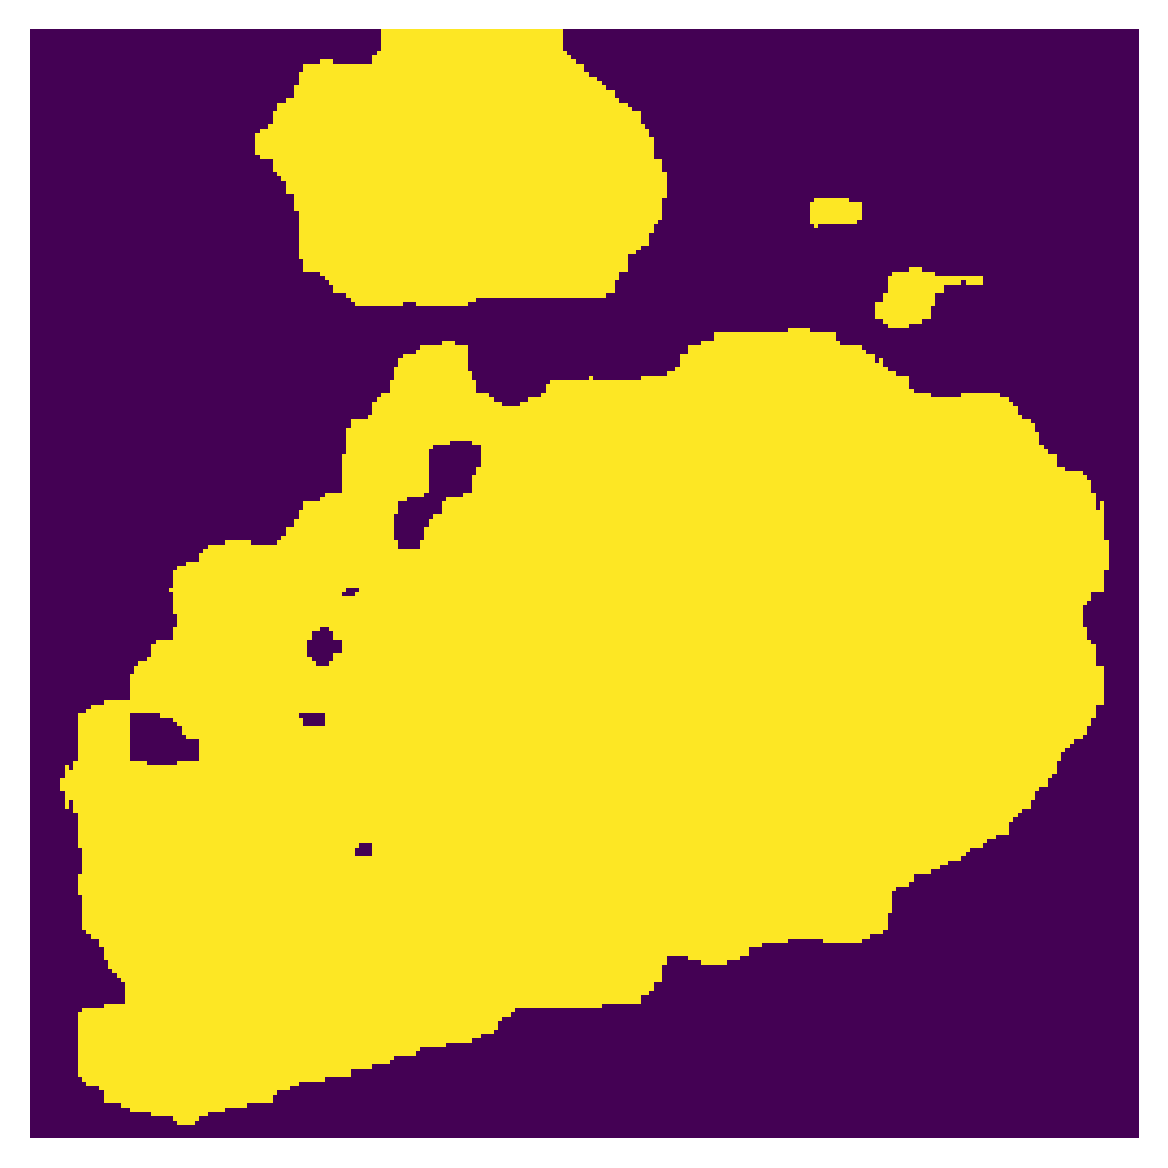

In [54]:
cell=img_gray<=0.8

plt.imshow(cell)
plt.axis("off")

### Divide into components

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

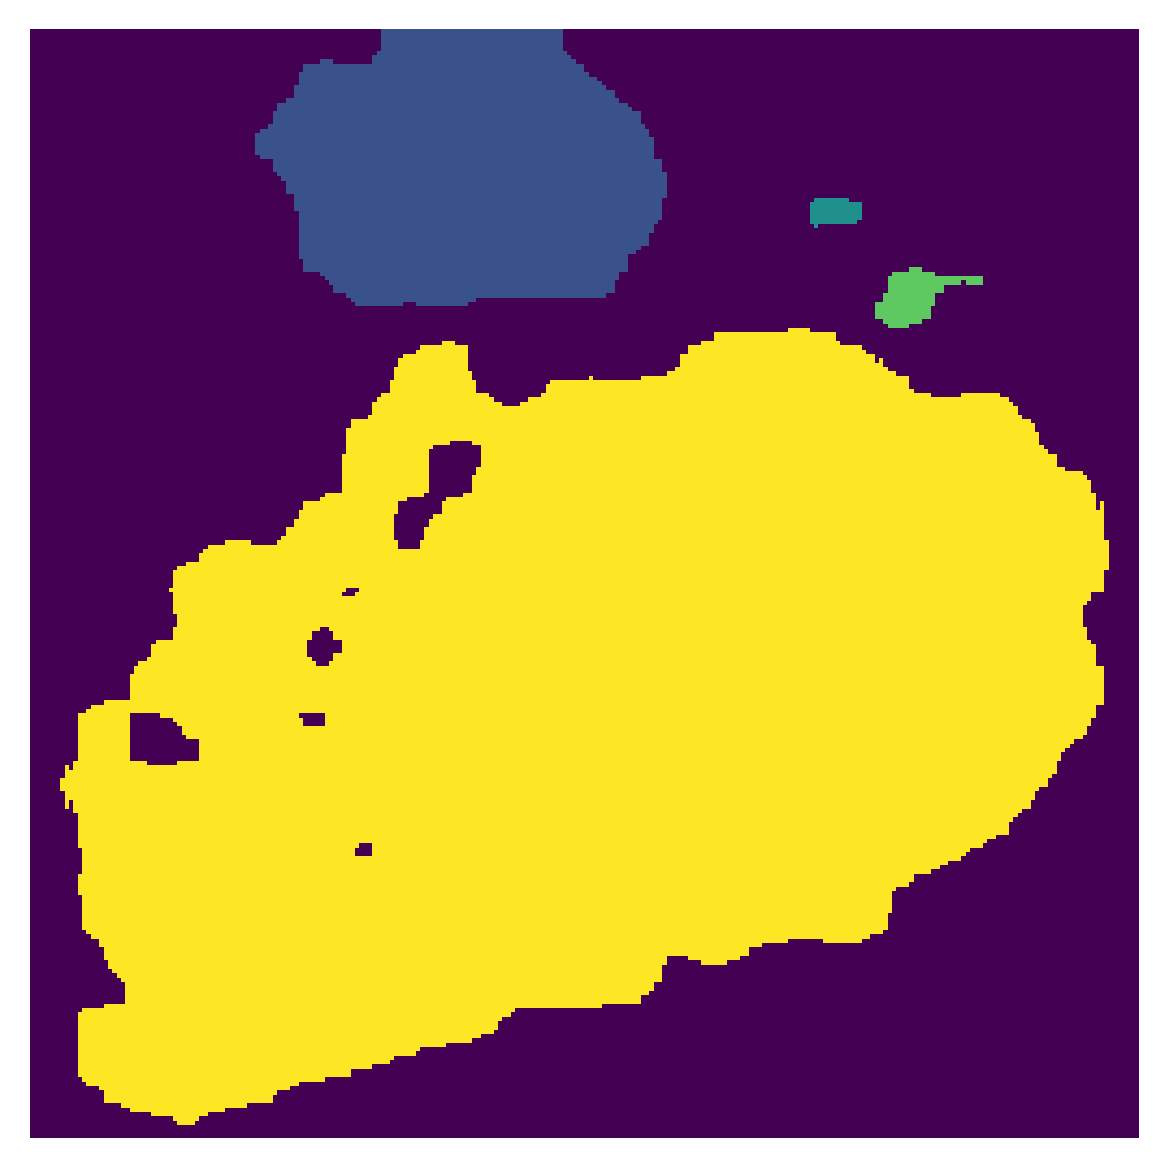

In [55]:
lbls=scilabel(cell)[0]
plt.imshow(lbls)
plt.axis("off")

## Sort components by area and take largest area component

In [60]:
rp=regionprops_table(lbls,properties=["label","area"])
rp=pd.DataFrame(rp).sort_values("area",ascending=False)
rp

,label,area
3,4,29590.0
0,1,4743.0
2,3,173.0
1,2,68.0


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

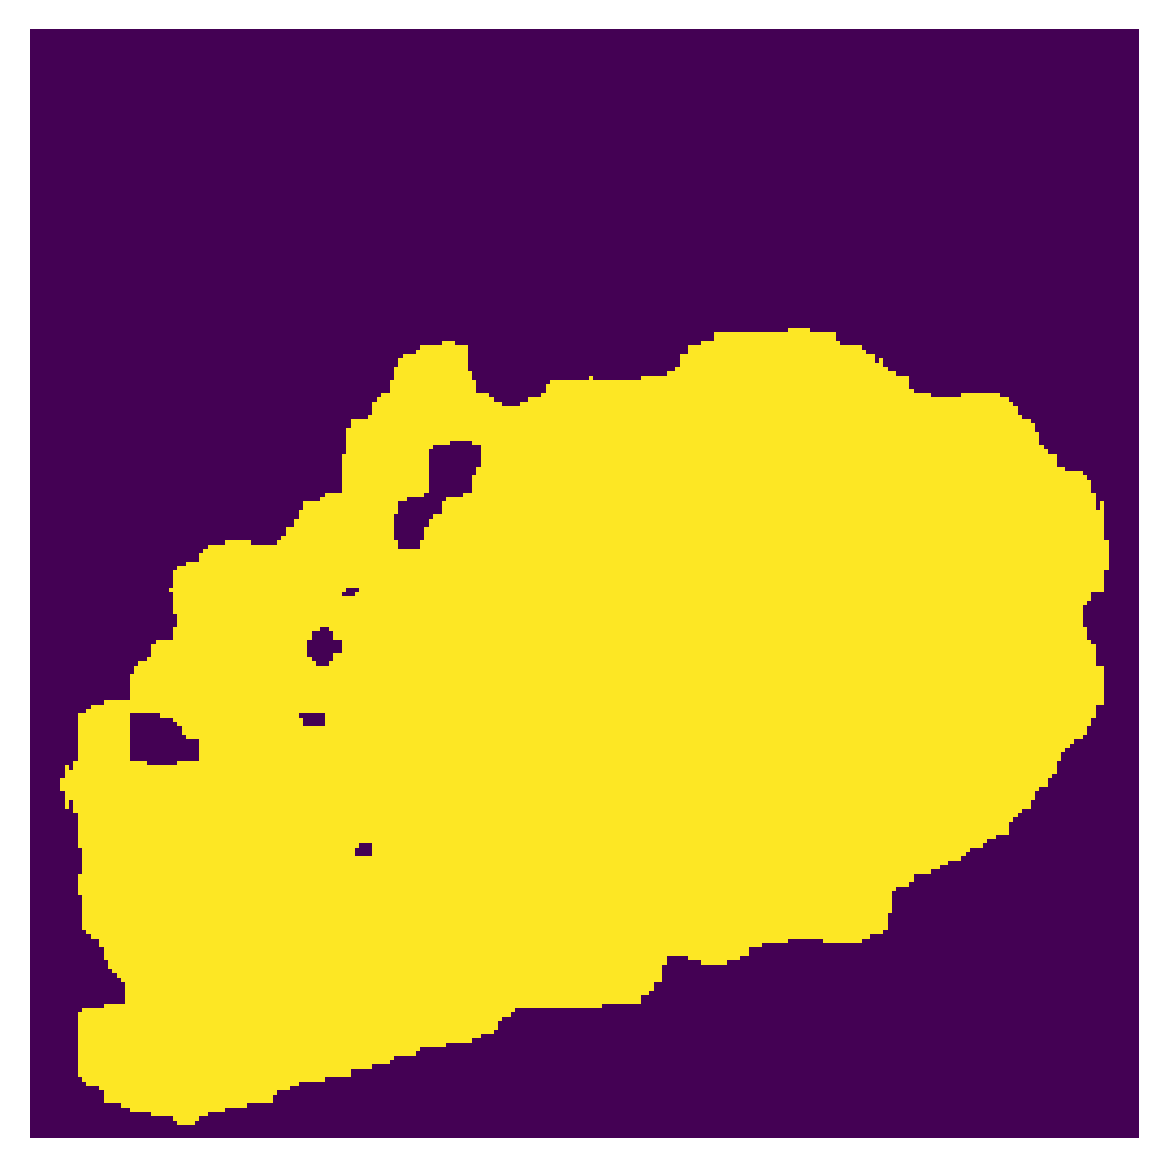

In [61]:
cell_filtered=(lbls==rp.iloc[0]['label'])
plt.imshow(cell_filtered)
plt.axis("off")

# Extract features for further analysis
## Example of a few morphological features

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

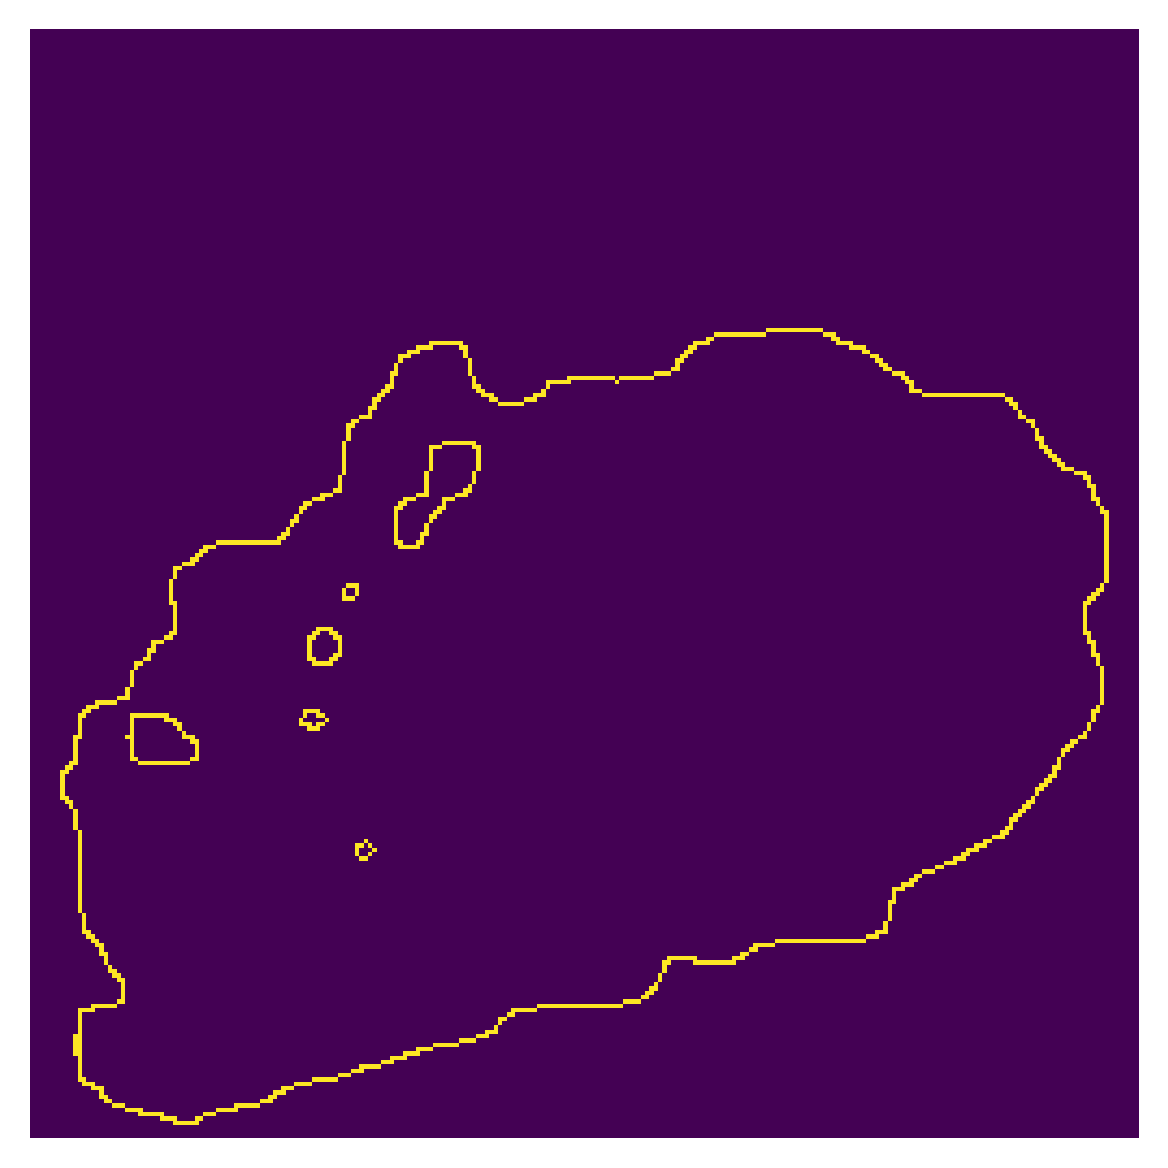

In [62]:
cell_filtered_canny=canny(lbls==rp.iloc[0]['label'].astype(float))
plt.imshow(cell_filtered_canny)
plt.axis("off")

In [63]:
PROPERTIES=['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'extent',
       'feret_diameter_max', 'filled_area', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'solidity']

pd.DataFrame(regionprops_table(cell_filtered.astype(int),properties=PROPERTIES)).T

,0
area,29590.000000
convex_area,32450.000000
eccentricity,0.827524
equivalent_diameter,194.100897
extent,0.664526
feret_diameter_max,271.516114
filled_area,30055.000000
major_axis_length,263.841664
minor_axis_length,148.128585
perimeter,1025.009235
